In [1]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import gekko as gk
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
import typing
import pymc
import itertools
import math
import functools
from pca import pca
from IPython.display import display, HTML
import prince
import networkx
import sklearn
import tensorflow as tf
from tensorflow import keras
import multiprocessing
from imblearn.over_sampling import ADASYN, SMOTE
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product
import arviz as az
import aesara

2022-11-04 15:51:43.647138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 15:51:43.647160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-04 15:51:43.675975: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 15:51:45.324328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-04 15:51:45.324627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [119]:
# Γενικές επιλογές εμφάνισης
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',30)

figsize=(13,6)
fontsize=10
sns.set(rc={'figure.figsize':(15,10),
           'font.size':5})

In [87]:
# Utilities
from sklearn.preprocessing import StandardScaler

std_scale = lambda df: pd.DataFrame(data = StandardScaler().fit_transform(df), columns = df.columns, index=df.index)

def render_df(df:pd.DataFrame):
    from IPython.display import display, HTML
    display(HTML(df.to_html()))
    return

def full_display(r=None, c=None):
    pd.set_option('display.max_rows', r)
    pd.set_option('display.max_columns',c)
    return

def reset_display():
    pd.set_option('display.max_rows',10)
    pd.set_option('display.max_columns',30)

def full_display_once(df:pd.DataFrame, r=None, c=None):
    full_display(r=r, c=c)
    render_df(df)
    reset_display()

def rowwise_value_counts(df:pd.DataFrame):
    vcounts_df = pd.DataFrame(data = df.apply(lambda x: x.value_counts()).T.stack()).astype(int).T
    vcounts_df.index = ['']
    return vcounts_df

invert_dict = lambda e: {v:k for k, v in e.items()}

def categorical_scatter(X:pd.DataFrame, Y:typing.Optional[pd.DataFrame],cols:int=3,max_rows:int = 3,
                             figsize:tuple[int, int] = (30, 15), xaxis_label_size: int=12,
                             yaxis_label_size:int=12, categorical:typing.Optional[str]='hue')->typing.Optional[plt.figure]:
    '''
        Generate pair-wise scatter plots for a given DataFrame, with optional support for large Datasets
        and categorical variables. Yields a figure with `max_rows x cols` scatterplots per call. When
        `categorical=None` only generates pair-wise scatterplots for the columns of X, else generates all
        combinations of X-column pair and Y columns. When `categorical='hue'` values of the categorical Y
        variable will be depicted color-coded and when `categorical=size` different factors of the Y variable
        will have different sizes instead.
        
        Args:
        -----
        
            - X:pandas.DataFrame := The data to depict. When Y is also specified, X is assumed to be the DataFrame
            of indicator variables
            
            - Y:Optional[pandas.DataFrame] := Optional Dataframe of categorical variables to depict. Ignored if 
            `category` is `None`.
            
            - idx_lvl:int=1 := For multilevel indexed dataframes the lowest level to squash the index on. Must be non-negative
            
            - cols:int=3 := Number of columns for the resulting facet grid plot. Must be non-negative. Defaults to 3
            
            - max_rows:int=3 := Maximum number of rows per batch the generator yields. Defaults to 3 and must be non-negative
            
            - figsize:tuple[int, int] := A `height x width` tuple for the generated plots. Defaults to `(30, 15)`
            
            - xaxis_label_size:int=12 := The size of the x-axis titles for each subplot. Must be non-negative and defaults to 12
            
            - yaxis_label_size:int=12 := The size of the y-axis titles for each subplot. Must be non-negative and defaults to 12
            
            - categorical:Optional[str] := Set the display of the categorical variable. (1) `None` ignores `Y` and only displays X
            pair-wise scatterplots, (2) 'hue' displays the categorical variable of `Y` as color and (3) 'size' displays
            the categorical variable with differently sized points
            
        Returns:
        --------
        
            - fig:matplotlib.pyplot.figure := The figure object, a FacetPlot of scatterplots
            
       
       Raises:
        ------
        
            - WIP
            
            - ValueError 
    '''
    XY = pd.concat([Y, X], axis=1)
    idx_lvl= XY.columns.nlevels-1
    skip_multiindex = lambda df,i , idx_level=idx_lvl: df.columns[i][idx_level] if idx_level else df.columns[i]
    if idx_lvl:
        XY.columns = XY.columns.get_level_values(idx_lvl)
    x_combs = math.comb(X.shape[1], 2)
    MAX_ROWS = max_rows
    
    if categorical is not None:
        plots = x_combs*Y.shape[1]
    else:
        plots = x_combs
    ncols = cols
    size_scaling_factor = None
    total_rows = math.ceil(plots/ncols)
    total_figures = math.ceil(total_rows/MAX_ROWS)
    X_pairs = itertools.combinations(range(X.shape[1]), 2)
    subplots = itertools.product(X_pairs,range(Y.shape[1]) ) if categorical is not None else X_pairs
    exhaustion_sentinel = False
    while True:
        if exhaustion_sentinel: break
        fig, axs = plt.subplots(nrows=MAX_ROWS, ncols=ncols, figsize=figsize)
        ax_indices = itertools.product(range(MAX_ROWS), range(ncols), repeat=1)
        plotslice = itertools.islice(subplots, MAX_ROWS*ncols)
        fig_generator = itertools.zip_longest( ax_indices, plotslice, fillvalue = ((None, None), None) )
        for (axi, axj), e in fig_generator:
            e = tuple(flatten(e))
            if e[0] is not None:
                if categorical == 'size':
                    sns.scatterplot(x=skip_multiindex(X, e[0]), y=skip_multiindex(X, e[1]), data=XY,
                       size=skip_multiindex(Y, e[2]), ax=axs[axi, axj], legend=True)
                elif categorical == 'hue':
                    sns.scatterplot(x=skip_multiindex(X, e[0]), y=skip_multiindex(X, e[1]), data=XY,
                       hue=skip_multiindex(Y, e[2]), ax=axs[axi, axj], legend=True)
                elif categorical is None:
                    sns.scatterplot(x=skip_multiindex(X, e[0]), y=skip_multiindex(X, e[1]), data=XY,
                       ax=axs[axi, axj], legend=True)
                axs[axi, axj].set_xlabel(skip_multiindex(X, e[0]))
                axs[axi, axj].set_ylabel(skip_multiindex(X, e[1]))
                axs[axi, axj].xaxis.label.set_size(xaxis_label_size)
                axs[axi, axj].yaxis.label.set_size(yaxis_label_size)
                
            else:
                axs[axi, axj].axis('off')
                exhaustion_sentinel = True
        yield fig 
    return None



def flatten(xs):
    from collections.abc import Iterable
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def tidy_multiindex(df:pd.DataFrame, sep:str="."):
    '''
        Compress a hierarchically indexed dataframe to standardized tidy
        format. A unique sepperator `sep` is used to allow reversal. All
        levels of the index are appended together with a delimeter to allow
        reversals.
        
        Args:
        ----
        
            - df:pandas.DataFrame := A `pandas.DataFrame` hierarchically indexed
            
            - sep:str='_._' := A delimenter delineating the different levels
            of the index. Ensure it is not present in any column name to avoid
            a malformed index
            
        Returns:
        --------
        
            - ndf:pandas.DataFrame := The DataFrame with a single-level index
    '''
    tidy_cols = (functools.reduce(lambda e1,e2: str(e1)+sep+str(e2), col ) for col in df.columns)
    ndf = df.copy(deep=True)
    ndf.columns = tidy_cols
    return ndf

def reverse_tidy_multiindex(df:pd.DataFrame, sep="."):
    '''
        Reverses the tidying to a hierachical format. Different
        levels of the index are identified based on "sep"
        
        Args:
        -----
        
            - df:pandas.DataFrame := The dataframe to process
            
            - sep:str='_._' := The string delimeter, sepperating
            values for different levels of the index
            
        Returns:
        -------
        
            - ndf:pandas.DataFrame := The dataframe with hierarchical index
    '''
    h_cols = (tuple(col.split(sep)) for col in df.columns)
    ndf = df.copy(deep=True)
    ndf.columns = pd.MultiIndex.from_tuples(h_cols)
    return ndf

def undummify(df:pd.DataFrame,cols:list[str, tuple[str]],ncol_name:typing.Union[str,tuple[str]],
              sep:typing.Optional[str]=None,
              rmap:typing.Optional[dict[int, typing.Union[str, tuple[str]]]]=None
             )->pd.DataFrame:
    '''
        Reverses hot-encoded variables in the DataFrame. A series of hot-encoded
        variable levels $(i_1, i2, \dots, i_k)$ is mapped to a single new column
        $(k)$, whose name is specified by `ncol_name`, in the new dataframe. Pre
        vious level columns are dropped.
        
        Args:
        ----
        
            - df:pandas.DataFrame := The DataFrame to operate upon
            
            - cols:list[str, tuple[str]] := A list of columns, representing the
            levels of a categorical variable
            
            - sep:Optional[str] := sepperator for variable level. Currently ignored
            
            - ncol_name:Union[str, tuple[str]] := Name of the new categorical column
            
            - remap:Optional[dict[int, Union[str, tuple[str]]]] := A dictionary mapping
            of categorical levels to values. Keys are the assumed to be levels, values
            are assumed to be values (i.e. strings). When provided, the previous levels
            will be replaced by the specified mappings in the new DataFrame
            
        Returns:
        -------
        
            - ndf:pandas.DataFrame := The processed dataframe
     '''
    _df = coredf.loc[:, cols]
    for i, col in enumerate(cols, 1):
        _df.loc[:, col] = i*_df.loc[:, col]
    ndf = df.copy(deep=True)
    ndf.drop(cols, axis=1, inplace=True)
    ndf[ncol_name] = _df.max(axis=1)
    c1 = df.columns.tolist()
    i = c1.index(cols[0])
    swp = ndf.columns.tolist()[:i-1]+[ndf.columns.tolist()[-1]]+ndf.columns.tolist()[i:-1]
    ndf = ndf.loc[:, swp]
    if rmap is not None:
        ndf = ndf.replace(rmap)
    return ndf
list_difference = lambda l1, l2: [e for e  in l1 if e not in set(l2)]

def corrspace_graph(df:pd.DataFrame):
    '''
        Generate a correlation graph representation of `df` datasets.
        Every node in the resulting graph is a variable and every 
        vertex between two nodes represents the correlation between
        the two variables, the correlation being the verted weight
        
        Args:
        ----
        
            - df:pandas.DataFrame := A dataset to depict
            
        Returns:
            - WIP
    '''
    
    return 


class DictTable(dict):
    '''
        Jupyter utility class that overrides the dicts' defaults
        __repr__ rendering the input dictionary to an HTML table
        for convenient jupyter rendering
    '''
    def _repr_html_(self):
        html = ["<table>"]
        for key, value in self.items():
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
    
def boxplots(df:pd.DataFrame, max_features:int=20, title:str="Boxplot",
             **kwargs)->typing.Generator[plt.Figure, None, None]:
    '''
        Wrapper around `pandas.boxplot` for datasets with a large number
        of features. Returns a generator of boxplots of subsets of the total
        features.
        
        Args:
        -----
        
            - df:pandas.DataFrame := The DataFrame to plot
            
            - max_features:int>0 := The maximum number of features to plot
            in each generated boxplot
            
            - title:str='Boxplot' := The title of the plot. A subplot index
            of the form **(X/Y)**, tracking the current plot will be
            appended prior to rendering
            
            - **kwargs:dict[str:Any] := Keyword arguments to be be forwarded
            to pandas.DataFrame.boxplot
            
        Returns:
        -------
        
            - Generator[plt.Figure, None, None] := A generator yielding boxplots
            of feature subsets
    '''
    nplots = math.ceil(df.shape[1]/max_features)
    for i in range(nplots):
        if (i+1)*max_features<df.shape[1]:
            ndf = df.iloc[:,i*max_features:(i+1)*max_features]
        else:
            ndf = df.iloc[:,i*max_features:df.shape[1]]
        fig = ndf.boxplot(**kwargs)
        fig.set_title(title + " ({current}/{total})".format(current=i+1, total=nplots) )
        yield fig
        
def count_missing_nan(df:pd.DataFrame, axis:int=0):
    '''
        Return a new DataFrame with the counts of missing
        and invalid values across specified axis.
        
        Args:
        -----
        
            - df:pandas.DataFrame := The data
            
            - axis:int=0 := The axis across which missing
            values will be enumerated. Defaults to 0 (show
            missing values in each column)
            
        Returns:
        -------
        
            - missing_df:pd.DataFrame := A DataFrame containing
            counts of missing values
    '''
    ndf = pd.DataFrame(df.isna().sum(axis=axis)).T
    ndf.index = ['']
    return ndf

In [4]:
def tf_model(Xtrain, Xtest, Ytrain, Ytest, loss:str='categorical_crossentropy',
             optimizer:str='adadelta',
             layers:typing.Optional[list[tuple[int, str]]]=None,
             metrics=['accuracy'], summary:bool=True, epochs:int=10,
             factivation:str='sigmoid',batch:int=64, callbacks:list=[],
            verbosity:int=1):
    M = Xtrain.shape[1]
    input_layer = tf.keras.Input(shape=(M,))
    x = input_layer
    for neurons, activation in layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)

    x = tf.keras.layers.Dense(math.ceil(Ytrain.shape[1]), activation=factivation)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=optimizer, loss=loss, 
                metrics=metrics)
    if summary:
        model.summary()
    model.fit(Xtrain, Ytrain, epochs=epochs, validation_data = (Xtest, Ytest),
              batch_size=batch, callbacks=callbacks, verbose=verbosity)
    return model

In [5]:
def tf_autoencoder(Xtrain, Xtest, Ytrain, Ytest, loss:str='categorical_crossentropy',
             optimizer:str='adadelta',
             layers:typing.Optional[list[tuple[int, str]]]=None,
             metrics=['accuracy'], summary:bool=True, epochs:int=10,
             activation:str='sigmoid',batch:int=64 ):
    M = X.shape[1]
    input_layer = tf.keras.Input(shape=(M,))
    x = input_layer
    rev_layers = copy(layers)
    rev_layers.reverse()
    for neurons, activation in layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)
    encoder = x
    for neurons, activations in rev_layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)
    x = tf.keras.layers.Dense(math.ceil(Ytrain.shape[1]), activation='sigmoid')(x)
    decoder = x
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=optimizer, loss=loss, 
                metrics=metrics)
    if summary:
        model.summary()
    model.fit(Xtrain, Ytrain, epochs=epochs, validation_data = (Xtest, Ytest),
              batch_size=batch, verbose=1)
    return model

In [6]:
df_raw = pd.read_excel("Συγκεντρωτικό Ελαιόλαδου.xlsx", decimal=',')

## Γενικά

Τα δεδομένα μας απαρτίζονται από χημικές και φυσικοχημεικές παραμέτρους, παραμέτρους χαρακτηρισμού προέλευσης (ποικηλία, γεωγραφική προέλευση) και δεδομένα εδαφικών χαρακτηριστικών. Τα εδαφικά δεδομένα είναι λιγοστά ώστε πρακτικά δεν θα χρησιμοποιηθούν καθόλου. Η ποικηλία εμπεριέχει και μικτούς χαρακτηρισμούς (πχ 60% αδραμυτιανή, 40% κολοβή). Οι παράμετροι χαρακτηρισμού προέλευσης (και μεθόδου παραγωγής) είναι κατηγορικές μεταβλητές και αντιπροσωπεύονται με "ενα σε Κ κωδικοποίηση" *(one-to-k encoding)*.
Οι χημικές παράμετροι διακρίνονται σε
1. αντιοξειδωτικά
2. χρωστικές
3. dags
4. στερόλες
5. λιπαρά οξέα
6. κήρους
7. αιθυλεστέρες

Οι φυσικοχημικές παράμετροι είναι:

1. οξύτητα
2. περοξείδια
3. συντελεστής ($Κ232$)
4. συντελεστής ($Κ270$)
5. συντελεστής ($ΔK$)

Οι οργανοληπτικές παράμετροι θα μοντελοποιηθούν χωριστά λόγο ιδιαιτεροτήτων τους και είναι:
1. Διάμεση τιμή φρουτώδους ($M_f$)
2. Διάμεση τιμή πικρού ($M_b$)
3. Διάμεση τιμή πικάντικου ($M_p$)
4. Διάμεση τιμή ελαττώματος ($M_d$) 
5. Παρατηρήσεις

Οι παράμετροι προέλευσεις μπορούν να διακριθούν περαιτέρο σε παραμέτρους "καλλιέργειας" (*cultivar*) και παραμέτρους παραγωγής (ή ελαιοποίησης *oilification*). Οι παράμετροι καλλιέργειας είναι:

1. Ποικηλία:
     * Κολοβή
     * Αδραμυτιανή
     * Λέσσινο
     * Λαδοελιά
     * Αγρινιότικη
     * Πατρινή
     * Κρητική
     * Κορωνέικη
     * Αρμπεκίνα
     * Χονδροελιά
     * Θρούμπα
     * Δαφνοελιά
     * Μανάκι
     * Άμφυσας
     * Καλάμων
     * Χιώτικη
2. Γεωγραφική Προέλευση:
    * Λέσβος
    * Σάμος
    * Χίος 
    * Ικαρία 
    * Φούρνοι
3. Άρδευση (boolean)
4. Λίπανση* (Κοπριά, Λίπανση, Ναι, Όχι) !!
5. Ωρίμανση (Π, ΠΑ, ΠΙ, Μ) (k-enc)
6. Οργανική Καλλιέργεια (boolean)
7. Υψόμετρο (Ορεινό, Ημιορεινό, Πεδινό) (k-enc)

Οι παράμετροι ελαιοποίησης είναι:

1. Ημέρες έως ελαιοποίηση
2. Μέθοδος συλλογής
    * Τεμπ
    * Μηχανικά (Μηχ. ελαι.)
    * Ελαίοδ
    * Δίχτυ
    * Σακ. Δικτ
    * Χτένι
3. Τύπος Φυγοκέντρισης (boolean)
4. Προσθήκη Νερού (boolean)
5. Χρόνος Μάλαξης (int>0)
6. Θερμοκρασία Μάλαξης (int>0)
7. Θερμοκρασία Διαχωριστήρα (int>0)

  Για ορισμένες ποικηλίες έχουμε ελάχιστες παρατηρήσεις (Πατρινή, Κρητική, Άμφυσας, Καλάμων) και δύσκολα μπορούμε να βγάλουμε συμπεράσματα. Η Λέσβος έχει διαχωριστεί σε υπό περιοχές - ζώνες. Θα μπορούσε να κατασκευαστεί μοντέλο γι αυτές ξεχωριστά (αφού οι υπόλοιπες περιοχές δεν διακρίνονται σε ζώνες). Για την λίπανση, έχουμε καταγραφές μορφής ΝΑΙ/ΟΧΙ στη μία παρτίδα και αναλυτικότερη (ΟΧΙ, ΚΟΠΡΙΑ, ΛΙΠΑΣΜΑ) στην άλλη. Συνεπώς αρχικά θα αναγάγουμε όλες τις καταγραφές σε  ΝΑΙ/ΟΧΙ χρησιμποιώντας και τα δύο σύνολα δειγμάτων και αργότερα μπορούμε να κατασκευάσουμε μοντέλο ιδιαίτερα για τη διάκριση Κοπριάς/Λιπάσματος. 
  Υπάρχουν αρκετές ελλειπής καταγραφές στις άνω κατηγορίες, συνεπώς αρχικά θα τις απορρίψουμε εντελώς και κατόπιν θα επιχειρήσουμε *imputation*. Οι περισσότερες κατηγορικές μεταβλητές-στόχοι προέλευσης μπορούν να αντιπροσωπευθούν με κ-κωδικοποίηση. Ιδιαίτερη περίπτωση αποτελεί η ποικηλία. Επειδή αυτή είναι σε πολλά δείγματα μεικτή, με γνωστές αναλογές, θα επιχειρήσουμε διαδικασία αντίστοιχη της κ-κωδικοποίησης, επιλύωντας πρόβλημα βελτιστοποίησης **υπό συνθήκες**. Θα επιχειρήσουμε να κατασκευάσουμε μοντέλο παλινδρόμησης ποσοστού κάθε ποικηλίας υπό συνθήκη αθροίσματος στη μονάδα. Για όλες τις υπόλοιπες παραμέτρους προέλευσης μπορούμε να χρησιμοποιήσουμε οποιοδήποτε μοντέλο classification, και επειδή η προέλευση έχει ιδιαιτερώτητες θα κατασκευάσουμε το αντίστοιχο μοντέλο χωριστά, τουλάχιστον στα αρχικά στάδια. Για τις μεθόδους συλλογής χρειαζομαστε διευκρινήσεις.

 Πιθανά μοντέλα ενδιαφέροντως
 * Γεωγραφικές Παράμετροι από χημικές
 * Οργανοληπτικές + Φυσικοχημικές από χημικές
 * Οργανοληπτικές + Φυσικοχημικές από προέλευση (path analysis?)
 * Σχέση παραμέτρων παραγωγής και προέλευσης σε ποιοτικές
 * SEM σε παραμέτρους ποιότητας

In [7]:
multindex = [
            np.array(['id']*3 + ['origin']*54 + ['chemical']*44 +['phys']*10+['chemical']*37 + ['soil']*20),
            np.array(['id']*3 + ['location']*2 + ['cultivar']*23+['cultivation']*9 +['production']*20+['antiox']*27+['pigm']*8+['dags']*9+['phys']*5+['org']*5+['f_acids']*15+['sterols']*20+['waxes', 'ethylesters']+['soil']*20),
            np.array(df_raw.columns.to_list())]
pdf = pd.DataFrame(data = df_raw.values, columns = multindex)
pdf.replace(
    {()}
)

id                                    origin                          \
       id                                  location           cultivar        
      gid                  tofid     dname       zn     loc       rvar uvar   
0    1043  1043KAMB_GA4_01_25728  1043ΚΑΜΒ      6.0  LESVOS    K50AD50    0   
1    1044  1044ELKP_GE8_01_25764  1044ΕΛΚΠ      7.0  LESVOS    K70AD30    0   
2    1066  1066ELKP_GB8_01_25861  1066ΕΛΚΠ      1.0  LESVOS   K60ADR40    0   
3    1074  1074KAGK_GC1_01_25862  1074ΚΑΓΚ      1.0  LESVOS   K50ADR50    0   
4    1087      1087_RE7_01_26470  1087ΕΛΣΓ      1.0  LESVOS     KOLOVI    0   
..    ...                    ...       ...      ...     ...        ...  ...   
530  9157                    NaN  X31 GILA      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   
531  9158                    NaN  X40 KOKG      1.0   CHIOS   ΘΡΟΥΜΠΑ     0   
532  9159                    NaN  X41 KOKS      1.0   CHIOS   ΘΡΟΥΜΠΑ     0   
533  9160                    NaN  X42 KOKS      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   
534  9161                    NaN   X43GIMM      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   

                                         ... soil                           \
                                         ... soil                            
    ucul  kol  kor lad adr  thr hon kal  ... cond caco orga nano  nnh phos   
0      0   50    0   0  50    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
1      0   70    0   0  30    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
2      0   60    0   0  40    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
3      0   50    0   0  50    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
4      0  100    0   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
..   ...  ...  ...  ..  ..  ...  ..  ..  ...  ...  ...  ...  ...  ...  ...   
530    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
531    0    0    0   0   0  100   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
532    0    0    0   0   0  100   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
533    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
534    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   

                                                   
                                                   
     bor kal.1  mag   ca zn.1   fe   cu   mn salt  
0    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
..   ...   ...  ...  ...  ...  ...  ...  ...  ...  
530  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
531  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
532  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
533  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
534  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[535 rows x 168 columns]

* Απορρίπτουμε την στήλη αθροίσματος "sum" γιατί δεν περιέχει πρωτότυπες πληροφορίες ενδιαφέροντως.
* Οι phph (φαιοφυτίνη), pph (πυροφαιοφυτίνη), dtoc (δ-τοκοφερόλη),bcarot (β-καροταίνιο)  και bctoc (β και γ τοκοφερόλη) απορρίπτονται γιατί έχουν μετρηθεί μόνο στο ένα σύνολο δειγμάτων και ακόμη και σε αυτό έχουν ελάχιστες καταγραφές.
* Η στήλη syrig απορρίπτεται γιατί υπάρχει μόνο στο ένα σύνολο δεδομένων και μάλλον είναι το εσωτερικό πρότυπο.
* Οι στήλες ouv, eryth απορρίπτονται γιατί έχουν μετρηθεί μόνο στο ένα σύνολο δεδομένων και απουσιάζουν από το άλλο.
* Απορρίπτεται η στήλη 'kadr' προέκυψε από την ομόνυμη καταγραφή ποικηλίας καθώς μάλλον είναι "(Κ)(Αδρ)" δηλαδή κολωβή και αδραμυτιανή σε άγνωστη αναλογία.
* Όλες οι παράμετροι 'soil' (εδαφικές) απορρίπτονται γιατί εάν και έχουν μεγάλο ενδιαφέρον, έχουμε ελάχιστες καταγραφές.

In [8]:
# Throw away problematic columns, too many missing values. Sum does not contain unique information
coredf = pdf.drop(columns=['phph','pph','dtoc','syrig','obs', 'eryth', 'ouv', 'bcarot', 'bctoc', 'sum', 'kadr'],level=2)
coredf = coredf.drop(columns=['soil'],level=0)
coredf = coredf.drop(columns=['dags'],level=1)
coredf = coredf.drop(columns=['rvar','org', 'alt', 'fert', 'mat', 'colmeth', 'watadd'], level=2)
# Replace <0.01 entries with zeros
coredf.replace('<0,01',0.00, inplace=True)
coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]] = coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]].astype('float64')
coredf.loc[:, 'origin']

/tmp/ipykernel_43080/2428789659.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]] = coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]].astype('float64')


location         cultivar                                                  \
          zn     loc     uvar ucul  kol  kor lad adr  thr hon kal man chi kou   
0        6.0  LESVOS        0    0   50    0   0  50    0   0   0   0   0   0   
1        7.0  LESVOS        0    0   70    0   0  30    0   0   0   0   0   0   
2        1.0  LESVOS        0    0   60    0   0  40    0   0   0   0   0   0   
3        1.0  LESVOS        0    0   50    0   0  50    0   0   0   0   0   0   
4        1.0  LESVOS        0    0  100    0   0   0    0   0   0   0   0   0   
..       ...     ...      ...  ...  ...  ...  ..  ..  ...  ..  ..  ..  ..  ..   
530      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   
531      1.0   CHIOS        0    0    0    0   0   0  100   0   0   0   0   0   
532      1.0   CHIOS        0    0    0    0   0   0  100   0   0   0   0   0   
533      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   
534      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   

         ... production                                             \
    cre  ...     mat_pi mat_p mat_m  doil colmeth_eld colmeth_eldi   
0     0  ...        1.0   0.0   1.0  10.0         0.0          0.0   
1     0  ...        1.0   0.0   1.0   1.0         0.0          0.0   
2     0  ...        0.0   0.0   0.0   0.0         0.0          0.0   
3     0  ...        1.0   0.0   1.0   5.0         0.0          0.0   
4     0  ...        1.0   0.0   1.0   4.0         0.0          0.0   
..   ..  ...        ...   ...   ...   ...         ...          ...   
530   0  ...        0.0   0.0   1.0   3.0         NaN          NaN   
531   0  ...        1.0   0.0   0.0   NaN         NaN          NaN   
532   0  ...        1.0   0.0   0.0   5.0         NaN          NaN   
533   0  ...        1.0   0.0   0.0   7.0         NaN          NaN   
534   0  ...        1.0   0.0   1.0   NaN         NaN          NaN   

                                                                             \
    colmeth_mhx colmeth_temp colmeth_dixt colmeth_xte centr watadd_b kbtemp   
0           0.0          1.0          0.0         0.0   3.0      0.0     70   
1           0.0          1.0          0.0         0.0   2.0      1.0     60   
2           0.0          1.0          0.0         0.0   2.0      1.0     90   
3           1.0          0.0          0.0         0.0   3.0      1.0     70   
4           0.0          1.0          0.0         0.0   2.0      1.0     90   
..          ...          ...          ...         ...   ...      ...    ...   
530         NaN          NaN          NaN         NaN   3.0      1.0     30   
531         NaN          NaN          NaN         NaN   3.0      0.0     40   
532         NaN          NaN          NaN         NaN   3.0      0.0     45   
533         NaN          NaN          NaN         NaN   3.0      0.0     45   
534         NaN          NaN          NaN         NaN   3.0      NaN     45   

                  
    kntemp stemp  
0     34.0  36.0  
1     26.0  27.0  
2     25.0  28.0  
3     34.0  34.0  
4     36.0  34.0  
..     ...   ...  
530   25.0  25.0  
531   32.0  32.0  
532   32.0  34.0  
533   29.0  31.0  
534   30.0  33.0  

[535 rows x 46 columns]

Κωδικοποιούμε τις διάφορες κατηγορικές παραμέτρους προέλευσης με κωδικοποίηση τύπου "ένα σε Κ" (*one-to-k-encoding*) όπου κάθε διακριτή τιμή αναπαρίσταται από θετικό ακαίρεο. Έτσι κάθε κατηγορική μεταβλητή $v=\{i_1,i_2,\dots,i_K\}$ με $Κ$ πιθανές τιμές, γίνεται $v=\{1,2\dots,K\}$ 

In [9]:
altitude_mapping = {'Mountainous': 3, 'Planar': 2, 'Semimountainous': 1}
location_mapping = {i:label  for i, label in enumerate(coredf.loc[:,('origin', 'location','loc')].unique(), 1)}
_c1 = ["colmeth_eld", "colmeth_eldi","colmeth_mhx", "colmeth_temp", "colmeth_dixt", "colmeth_xte"]
bin_map = {0.0:'No', 1.0: 'Yes', 1:'Yes', 0:'No'}
_c2 = {('origin', 'production', v):bin_map for v in _c1}
_c3 = ["mat_null", "mat_pa", "mat_pi", "mat_p", "mat_m"]
_c4 = {('origin', 'production', v):bin_map for v in _c3}
core_mappings = {
        ('origin', 'cultivation', 'org_b'): {0:'Conventional', 1: 'Organic', 0.0:'Conventional', 1.0:'Organic'},
        ('origin', 'cultivation', 'fert_b'): {0: 'No', 1: 'Fertilized'},
        ('origin', 'cultivation', 'wat'): {1: 'Yes', 0: 'No'},
        ('origin', 'cultivation', 'altitude'): invert_dict(altitude_mapping),
        ('origin', 'location', 'loc') : location_mapping,
        ("origin", "production", "watadd_b"):{0.0:"No", 1.0:"Yes"},
        ('origin', 'production', 'centr'):{3.0:"3PH", 2.0:"2PH"}
    }
r_core_mappings = {k: invert_dict(v) for k, v in core_mappings.items()}

In [10]:
DictTable(r_core_mappings)

"('origin', 'cultivation', 'org_b')","{'Conventional': 0, 'Organic': 1}"
"('origin', 'cultivation', 'fert_b')","{'No': 0, 'Fertilized': 1}"
"('origin', 'cultivation', 'wat')","{'Yes': 1, 'No': 0}"
"('origin', 'cultivation', 'altitude')","{'Mountainous': 3, 'Planar': 2, 'Semimountainous': 1}"
"('origin', 'location', 'loc')","{'LESVOS': 1, 'IKARIA': 2, 'SAMOS': 3, 'FOURNOI': 4, 'CHIOS': 5}"
"('origin', 'production', 'watadd_b')","{'No': 0.0, 'Yes': 1.0}"
"('origin', 'production', 'centr')","{'3PH': 3.0, '2PH': 2.0}"


In [11]:
c = [('origin', 'cultivation', 'alt_ped'), ('origin', 'cultivation', 'alt_or'), ('origin', 'cultivation', 'alt_sem')]
cdf = undummify(coredf, cols =c,rmap={('origin', 'cultivation', 'altitude'):invert_dict(altitude_mapping)}, ncol_name=('origin', 'cultivation', 'altitude'))

In [12]:
# For some reason the replace doesn't work properly on 'watadd_b' when included with all the others, but does work when handdled sepperatly.
cdf = cdf.replace(core_mappings|_c2|_c4).replace({("origin", "production", "watadd_b"):{1.0:"Yes", 0.0:"No"}})

In [13]:
_c = [("origin","location", "zn"), ("origin","location", "loc")]+list(_c2.keys())+list(_c4.keys())+[
    ("origin", "production", "centr"), ("origin", "production", "watadd_b"), ("origin", "cultivation", "altitude"),("origin", "cultivation", "org_b")]
cdf.loc[:,('origin', 'location', 'zn')] = cdf.loc[:,('origin', 'location', 'zn')].astype(pd.Int64Dtype())
cdf.loc[:,_c]=cdf.loc[:,_c].astype('category')

/tmp/ipykernel_43080/3400965392.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cdf.loc[:,_c]=cdf.loc[:,_c].astype('category')


Μας ενδιαφέρει να προβλέψουμε παραμέτρους που σχέτιζονται με τις φυσικοχημικές ιδιότητες, την προέλευση, τα οργανοληπτικά χαρακτηριστικά και τις φυσικοχημικές ιδιότητες. Θα επικεντρωθούμε κυρίως στη **αυθεντηκοποίηση** προβλέπωντας τις διάφορες παραμέτρους προέλευσης του λάδιου. Αρχικά θα βασιστούμε στις χημικές παραμέτρους. Διακρίνουμε τις μεταβλητές στόχους σε:

* Μεταβλητές γεωγραφικής προέλευσης (*cultivation, location*)
* Μεταβλητές παραγωγής και ελαιoποίσης (*production*)
* Μεταβλητές ποικηλίας (*cultivar*)

Ιδιαίτερα, η ποικηλία θα μοντελοποιηθεί χωριστά από τις υπόλοιπες καθώς στα αρχικά δεδομένα, η ποικηλία καταγράφεται ως ποσοστιαίο μίγμα ποικηλιών αντί απλού χαρακτηρισμού, επομένως θα πρέπει να κατασκευάσουμε μοντέλο παλινδρόμησης, αντί κατηγοριοποίησης (εν και θα μπορούσαμε να αναγάγουμε το πρόβλημα σε πρόβλημα κατηγοριοποίησης). Εκτός της ποικηλίας, οι υπόλοιπες μεταβλητές είναι κατηγορικές αλλά ετερογενείς. Κάποιες είναι Δυονυμικές άλλες Πολυταξικές (γενικά χωρίς αλληλοεπικάλυψη)

Συγκεκριμένα:

* Ο τύπος καλλιέργειας (*org_b*) είναι Δυαδικές
* Η λίπανση (*fert_b*) είναι Δυαδική
* Η ύδρευση (*wat*) είναι Δυαδική
* H φυγοκέντριση (*centr*) μπορεί να θεωρηθεί Δυαδική ή και Πολυταξική (δύο τάξεων)
* H (γεωγραφική) προέλευση (*location*) είναι πολυταξική (*multiclass*) μονής ετικέτας (*single-label*), γιατί δεν υπάρχει αλληλοεπικάλυψη μεταξύ των γεωγραφικών προελεύσεων
* Το υψόμετρο (*alt*) είναι πολυταξική (*multiclass*) μονής ετικέτας (*single-label*) - δεν υπάρχει αλληλοεπικάλυψη μεταξύ των υψόμετρων. Θα μπορούσε να θεωρηθεί και "πολλαπλής ετικέτας" με δύο ετικέτες ('Ορεινό', 'Πεδινό') και το 'Ημιπεδινό' να αντιπροσωπεύει την αλληλοεπικάλυψη
* Η ωρίμανση (*mat*) είναι πολυταξική με πολλαπλές ετικέτες. Επειδή κάθε κελί στα αρχικά δεδομένα ουσιαστικά περιείχε πολλαπλές καταγραφές (*Π, ΠΑ, ΠΙ, Μ*) η αρχική μεταβλητή κωδικοποιήθηκε με "ενα-σε-Κ" κωδικοποίηση, με 4 αλληλοεπικαλυπτόμενες μεταβλητές Δυαδικού τύπου, κάθε μία απ' τις οποίες αντιπροσωπεύει επίπεδο της αρχικής μεταβλητής
* Η μέθοδος συλλογής (*colmeth*) είναι πολυταξική με πολλαπλές ετικέτες. Πολλές καταγραφές της είναι ασαφείς και χρειάζονται διερεύνηση
* Ο χρόνος μάλλαξης (*kntime*) είναι συνεχής, θετική
* Η θερμοκρασία μάλλαξης (*kntemp*) είναι συνεχής, θετική
* Η θερμοκρασία διαχωριστήρα (*septemp*) είναι συνεχής και θετική

Οι μεταβλητές-στόχοι είναι ιδιαίτερα ετερογενείς και απαιτούν μια μίξη από προβλήματα κατηγοριοποίησης και παλινδρόμησης

## Διερευνιτική Ανάλυση Δεδομένων

### Περιγραφική Στατιστική

Πριν προχωρίσουμε σε μοντελοποίηση, θα διερευνηθούν τα δεδομένα με τεχνικές διερευνητικής ανάλυσης δεδομένων (*exploratory data analysis*). Εξαιτάζουμε κατηγορικές (μεταβλητές-στόχοι) και συνεχείς (μεταβλητές-
πρόβλεψης) παραμέτρους χωριστά.

#### Συνεχείς Χημικές Μεταβλητές

In [14]:
boxtitle='Chemical Parameter Distribution Boxplot'
kwargs=dict(rot=60, figsize=(15,7),
                fontsize=fontsize*.9, grid=True, patch_artist=True,
            flierprops={'marker': '.', 'markersize': 10,
                        'markerfacecolor': 'Yellow',
                       'markeredgewidth':0.7},
           color='Blue')
gf = boxplots(tidy_multiindex(coredf.loc[:,'chemical']),title=boxtitle, **kwargs)

<AxesSubplot: title={'center': 'Chemical Parameter Distribution Boxplot (1/4)'}>

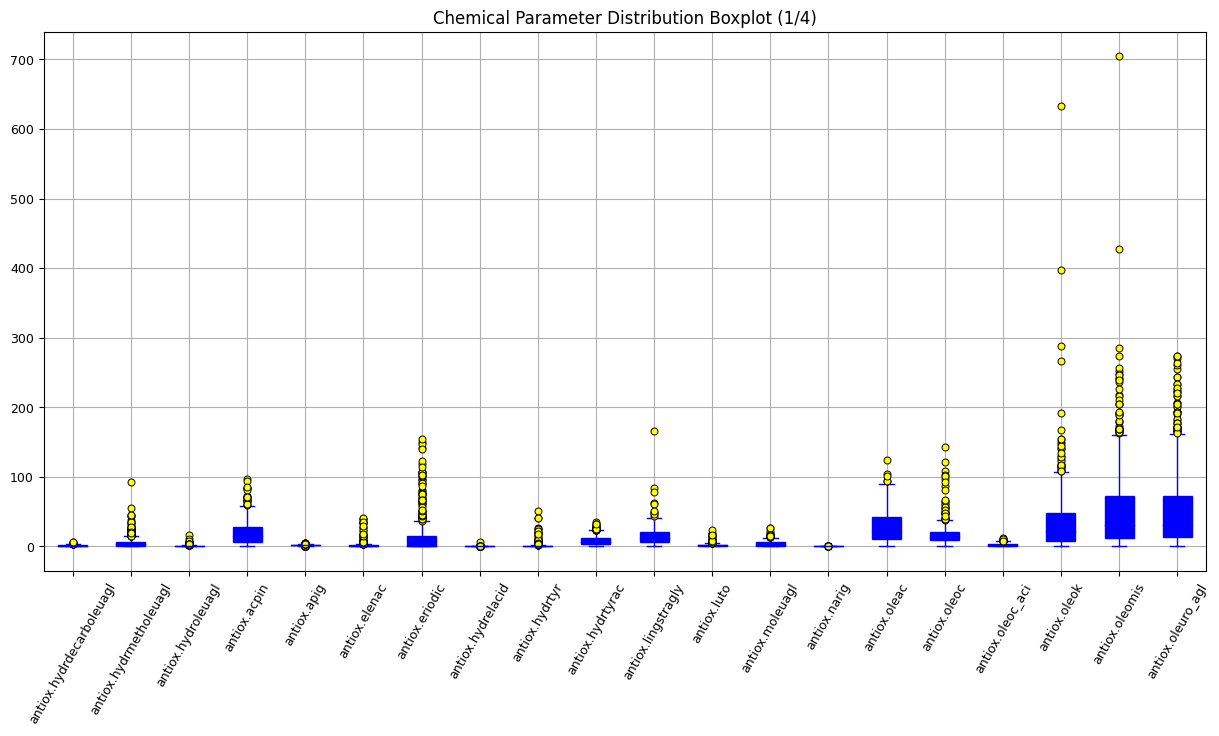

In [15]:
next(gf)

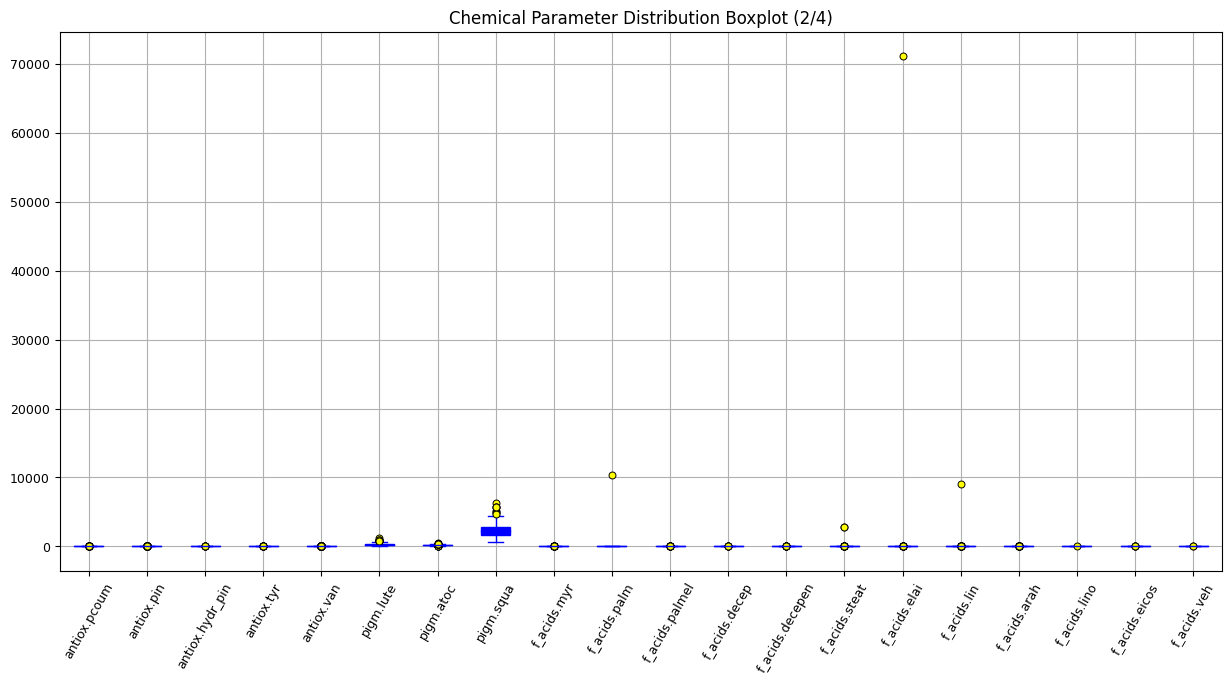

In [16]:
plt.show()
next(gf)
plt.show()

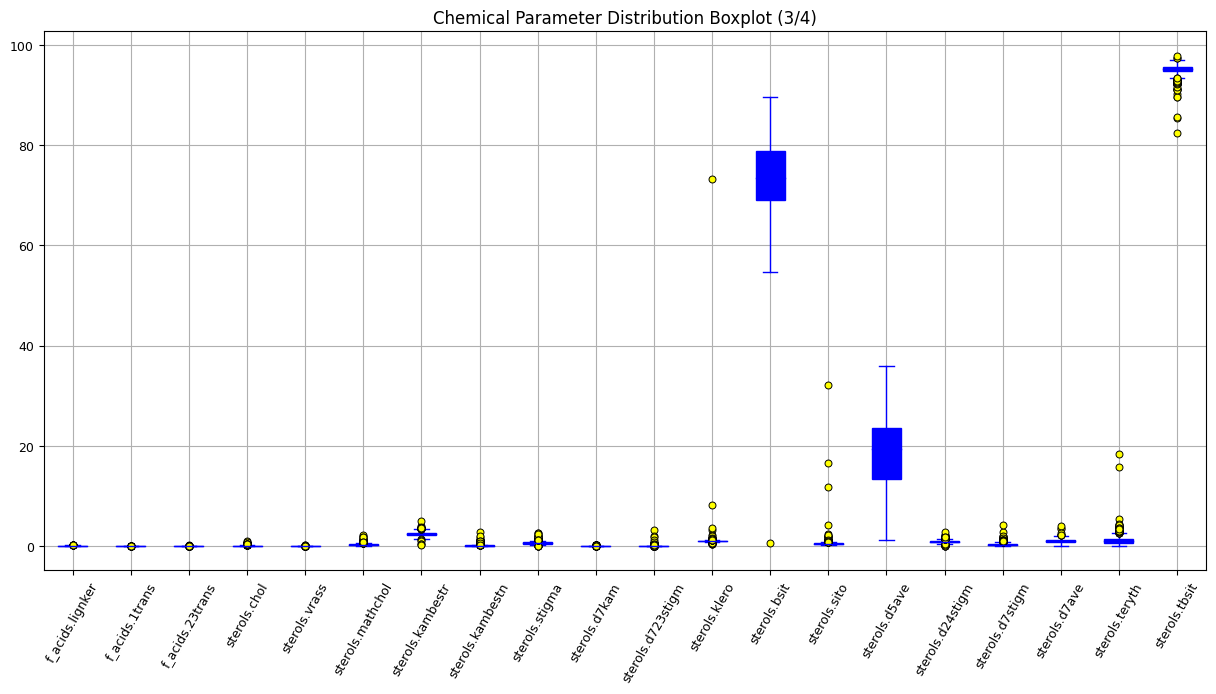

In [17]:
plt.show()
next(gf)
plt.show()

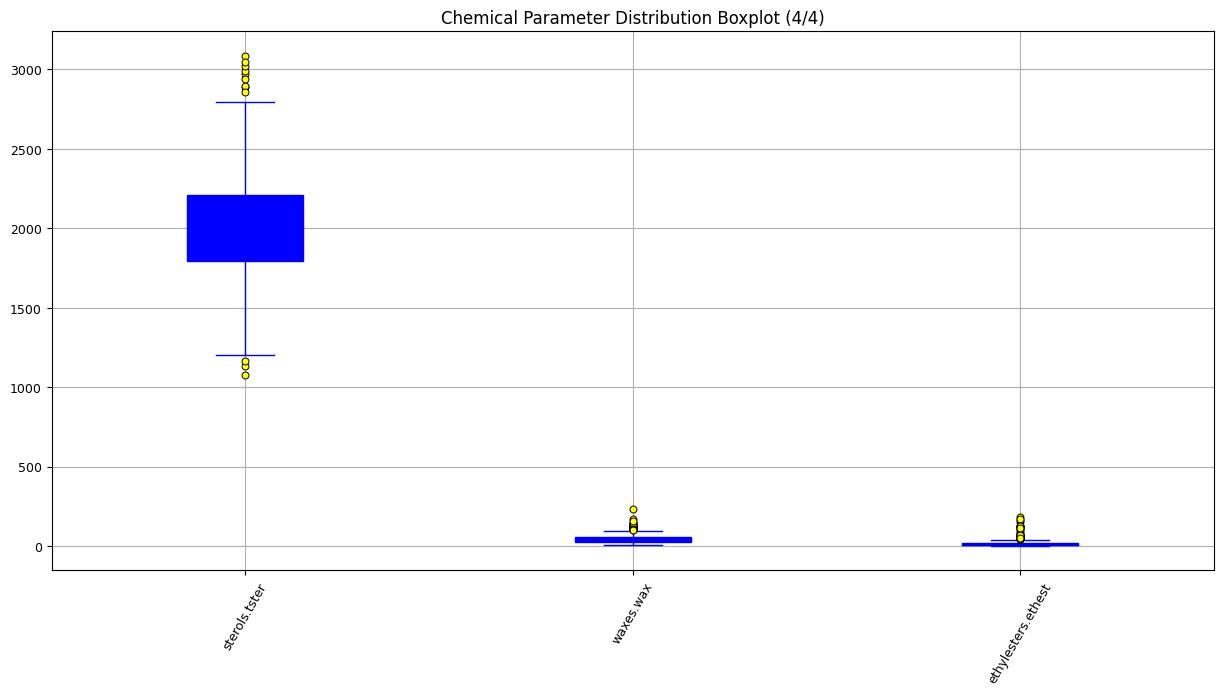

In [18]:
plt.show()
next(gf)
plt.show()

In [ ]:
cdf[cdf.loc[:, ("origin","cultivar")].isna().any(axis=1)]

Οι χημικές παράμετροι εμφανίζουν σημαντική ετερογένεια ως προς τις κατανομές τους και πιθανές έκτροπές. Για να χρησιμοποιηθούν θα πρέπει να υποστούν τυπική κλιμάκωση γιατί όπως φαίνεται αρκετές από αυτές διαφέρουν κατά ολόκληρες τάξεις μεγέθους, κάτι που θα μπορούσε να οδηγήσει σε μεροληπτικά μοντέλα. Αρκετές από αυτές είναι και σε εντελώς διαφορετικές μονάδες, οπότε θα πρέπει να επανεκφραστούν σε μονάδες τυπικής απόκλισης.

In [22]:
# full_display_once(coredf.describe())
coredf.describe()

id      origin                                      \
                id    location    cultivar                           
               gid          zn        uvar        ucul         kol   
count   535.000000  484.000000  535.000000  535.000000  535.000000   
mean   5667.616822    3.014463    0.071028    0.056075   51.248598   
std    2867.501151    2.190181    0.257112    0.230281   46.151638   
min    1043.000000    1.000000    0.000000    0.000000    0.000000   
25%    2360.500000    1.000000    0.000000    0.000000    0.000000   
50%    6202.000000    2.000000    0.000000    0.000000   50.000000   
75%    9027.500000    5.000000    0.000000    0.000000  100.000000   
max    9161.000000    7.000000    1.000000    1.000000  100.000000   

                                                                               \
                                                                                
              kor         lad         adr         thr         hon         kal   
count  535.000000  535.000000  535.000000  535.000000  535.000000  535.000000   
mean    13.338318    1.321495   15.194393    7.444860    0.224299    0.213084   
std     32.524717    9.417561   30.673092   25.126501    4.407409    2.571709   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000   10.000000    0.000000    0.000000    0.000000   
max    100.000000  100.000000  100.000000  100.000000  100.000000   40.000000   

                                                       ...    chemical  \
                                                       ...     sterols   
              man         chi         kou         cre  ...      stigma   
count  535.000000  535.000000  535.000000  535.000000  ...  535.000000   
mean     0.678505    0.841121    0.186916    0.280374  ...    0.612375   
std      6.262471    8.881397    4.323377    4.830060  ...    0.305365   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.444396   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.550277   
75%      0.000000    0.000000    0.000000    0.000000  ...    0.701475   
max    100.000000  100.000000  100.000000  100.000000  ...    2.588087   

                                                                               \
                                                                                
            d7kam   d723stigm       klero        bsit        sito       d5ave   
count  535.000000  535.000000  535.000000  535.000000  535.000000  535.000000   
mean     0.019957    0.052098    1.132431   73.696271    0.565755   18.663435   
std      0.036056    0.204695    3.141640    7.236314    1.640878    6.744082   
min      0.000000    0.000000    0.378366    0.683995    0.096551    1.193490   
25%      0.000000    0.000000    0.916546   69.057351    0.307797   13.279840   
50%      0.000000    0.000000    0.970448   73.413361    0.382096   19.324996   
75%      0.030000    0.015835    1.023313   78.825770    0.497337   23.528186   
max      0.200000    3.120000   73.153215   89.588561   32.130987   35.969047   

                                                                   \
                                                                    
         d24stigm     d7stigm       d7ave      teryth       tbsit   
count  535.000000  535.000000  535.000000  535.000000  535.000000   
mean     0.905972    0.379524    1.011863    1.193767   95.016513   
std      0.293674    0.335106    0.469968    1.228305    1.295491   
min      0.033921    0.005116    0.009463    0.057434   82.530000   
25%      0.760744    0.205583    0.721731    0.682002   94.752264   
50%      0.883406    0.281795    0.951765    1.037470   95.262456   
75%      1.009714    0.45

#### Μεταβλητές Στόχοι

Εξαιτάζονται όλες οι κατηγορικές μεταβλητές-στόχοι. Αρκετές από αυτές έχουν πολλές ελλειπείς τιμές σε πολλαπλές στήλες

In [65]:
# Data selection
all_origin_targets = cdf.loc[:,("origin", ['cultivation','location','production'])  ].drop(('origin', 'location', 'zn'), axis=1).drop(
    ('origin', 'production','kbtemp'), axis=1).drop(('origin', 'production','kntemp'), axis=1).drop(
    ('origin', 'production','stemp'), axis=1).drop(('origin', 'production','doil'), axis=1)
m1 = all_origin_targets.isna().any(axis=1)
chem_indicators =cdf.loc[:,(['chemical'])]
m2 = chem_indicators.isna().any(axis=1)
m3 = all_origin_targets.loc[all_origin_targets.loc[:,('origin', 'production', 'mat_null')]=='Yes']
m = pd.concat([m1, m2, m3],axis=1).any(axis=1)
chem_indicators, all_valid_origin_targets = chem_indicators.loc[~m,:], all_origin_targets.loc[~m,:]
all_origin_targets

origin                                                          \
      cultivation                       location production                 
            org_b         altitude  wat      loc   mat_null mat_pa mat_pi   
0    Conventional      Mountainous   No   LESVOS         No    Yes    Yes   
1    Conventional  Semimountainous  Yes   LESVOS         No    Yes    Yes   
2    Conventional  Semimountainous  Yes   LESVOS         No    Yes     No   
3    Conventional  Semimountainous  Yes   LESVOS         No    Yes    Yes   
4    Conventional  Semimountainous   No   LESVOS         No    Yes    Yes   
..            ...              ...  ...      ...        ...    ...    ...   
530       Organic  Semimountainous  Yes    CHIOS         No    Yes     No   
531       Organic      Mountainous   No    CHIOS         No     No    Yes   
532       Organic      Mountainous   No    CHIOS         No     No    Yes   
533       Organic      Mountainous   No    CHIOS         No     No    Yes   
534       Organic  Semimountainous  Yes    CHIOS         No    Yes    Yes   

                                                                   \
                                                                    
    mat_p mat_m colmeth_eld colmeth_eldi colmeth_mhx colmeth_temp   
0      No   Yes          No           No          No          Yes   
1      No   Yes          No           No          No          Yes   
2      No    No          No           No          No          Yes   
3      No   Yes          No           No         Yes           No   
4      No   Yes          No           No          No          Yes   
..    ...   ...         ...          ...         ...          ...   
530    No   Yes         NaN          NaN         NaN          NaN   
531    No    No         NaN          NaN         NaN          NaN   
532    No    No         NaN          NaN         NaN          NaN   
533    No    No         NaN          NaN         NaN          NaN   
534    No   Yes         NaN          NaN         NaN          NaN   

                                             
                                             
    colmeth_dixt colmeth_xte centr watadd_b  
0             No          No   3PH       No  
1             No          No   2PH      Yes  
2             No          No   2PH      Yes  
3             No          No   3PH      Yes  
4             No          No   2PH      Yes  
..           ...         ...   ...      ...  
530          NaN         NaN   3PH      Yes  
531          NaN         NaN   3PH       No  
532          NaN         NaN   3PH       No  
533          NaN         NaN   3PH       No  
534          NaN         NaN   3PH      NaN  

[535 rows x 17 columns]

In [76]:
t1 = rowwise_value_counts(all_origin_targets).astype(int).iloc[:,:22]
t1

origin                                                               \
  cultivation                                                     location   
        org_b            altitude                         wat          loc   
 Conventional Organic Mountainous Planar Semimountainous   No Yes    CHIOS   
          292     203         214    159             130  446  78       43   

                                                                               \
                             production                                         
                               mat_null     mat_pa      mat_pi      mat_p       
 FOURNOI IKARIA LESVOS SAMOS         No Yes     No  Yes     No  Yes    No Yes   
       6     29    399    58        493  41    356  178    204  330   496  38   

             
             
 mat_m       
    No  Yes  
   243  291

In [77]:
t2 = rowwise_value_counts(all_origin_targets).astype(int).iloc[:,22:]
t2

origin                                                          \
  production                                                           
 colmeth_eld     colmeth_eldi     colmeth_mhx      colmeth_temp        
          No Yes           No Yes          No  Yes           No  Yes   
         382  24          404   2         188  218          205  201   

                                                            
                                                            
 colmeth_dixt     colmeth_xte     centr      watadd_b       
           No Yes          No Yes   2PH  3PH       No  Yes  
          404   2         402   4   191  331      285  184

Οι παράγοντες της κάθε μεταβλητής είναι γενικά ανισσόροποι, με πολλά δείγματα σε μία τάξη και πολύ λιγότερα σε άλλες. Για παράδειγμα
1. Υπάρχουν σχεδόν $\approx 40\%$ περισσότερα συμβατικά δείγματα έναντι βιολογικών
2. Σχεδόν 400 δείγματα απ' τη Λέσβο και μόνο 6 από τους Φούρνους
3. Σχεδόν $4x$ περισσότερα δείγματα χωρίς άρδευση

Αυτή η ανισοσσοπία μπορεί να οδηγήσει σε μεροληπτικά μοντέλα. Το πρόβλημα θα μπορούσε να αντιμετοπιστεί με τεχνικές υπερ-δειγματοληψίας (*oversampling*), όπου κατασκευάζονται συνθετικά δείγματα βάση παρατηρούμενων κατανομών για να ενισχυθούν οι τάξεις με πολύ χαμηλό αριθμό δειγμάτων. Υπάρχουν επίσης πολλές κενές καταγραφές. Θα μπορούσε να γίνει διαδικασία *imputation* σε αυτές τις απούσες τιμές.

In [88]:
count_missing_nan(all_origin_targets)

origin                                                             \
 cultivation              location production                             
       org_b altitude wat      loc   mat_null mat_pa mat_pi mat_p mat_m   
          40       32  11        0          1      1      1     1     1   

                                                                             \
                                                                              
 colmeth_eld colmeth_eldi colmeth_mhx colmeth_temp colmeth_dixt colmeth_xte   
         129          129         129          129          129         129   

                 
                 
 centr watadd_b  
    13       66

Υπάρχουν 129 δείγματα χωρίς καταγραφή 'μεθόδου συλλογής', συνέπως είναι προτειμότερο αυτός ο στόχος να μοντελοποιηθεί χωριστά από τις υπόλοιπες, για να μην υποβαθμιστέι η ποιοτητα των προβλέψεων. Εάν περιοριστούμε στα δείγματα με πλήρεις καταγραφές σε όλες τις παραμέτρους:

In [91]:
t3 = rowwise_value_counts(all_valid_origin_targets).astype(int).iloc[:,:22]
t3

origin                                                               \
  cultivation                                                     location   
        org_b            altitude                         wat          loc   
 Conventional Organic Mountainous Planar Semimountainous   No Yes    CHIOS   
          249     116         141    123             101  309  56        7   

                                                                               \
                             production                                         
                               mat_null     mat_pa      mat_pi      mat_p       
 FOURNOI IKARIA LESVOS SAMOS         No Yes     No  Yes     No  Yes    No Yes   
       0      0    316    42        365   0    236  129    117  248   346  19   

             
             
 mat_m       
    No  Yes  
   139  226

In [92]:
t4 = rowwise_value_counts(all_valid_origin_targets).astype(int).iloc[:,22:]
t4

origin                                                          \
  production                                                           
 colmeth_eld     colmeth_eldi     colmeth_mhx      colmeth_temp        
          No Yes           No Yes          No  Yes           No  Yes   
         351  14          363   2         162  203          177  188   

                                                            
                                                            
 colmeth_dixt     colmeth_xte     centr      watadd_b       
           No Yes          No Yes   2PH  3PH       No  Yes  
          363   2         363   2   138  227      227  138

In [95]:
t5 = pd.concat([rowwise_value_counts(all_origin_targets).astype(int),rowwise_value_counts(all_valid_origin_targets).astype(int)])
t5.index = ['All values', 'Valid Only']
t5.iloc[:,:22]

origin                                                      \
            cultivation                                                       
                  org_b            altitude                         wat       
           Conventional Organic Mountainous Planar Semimountainous   No Yes   
All values          292     203         214    159             130  446  78   
Valid Only          249     116         141    123             101  309  56   

                                                                       ...  \
           location                             production             ...   
                loc                               mat_null     mat_pa  ...   
              CHIOS FOURNOI IKARIA LESVOS SAMOS         No Yes     No  ...   
All values       43       6     29    399    58        493  41    356  ...   
Valid Only        7       0      0    316    42        365   0    236  ...   

                                                                            \
                                                                             
           colmeth_eld colmeth_eldi     colmeth_mhx      colmeth_temp        
                   Yes           No Yes          No  Yes           No  Yes   
All values          24          404   2         188  218          205  201   
Valid Only          14          363   2         162  203          177  188   

                                                                      
                                                                      
           colmeth_dixt     colmeth_xte     centr      watadd_b       
                     No Yes          No Yes   2PH  3PH       No  Yes  
All values          404   2         402   4   191  331      285  184  
Valid Only          363   2         363   2   138  227      227  138  

[2 rows x 38 columns]

In [96]:
t5.iloc[:,22:]

origin                                                     \
            production                                                      
           colmeth_eld     colmeth_eldi     colmeth_mhx      colmeth_temp   
                    No Yes           No Yes          No  Yes           No   
All values         382  24          404   2         188  218          205   
Valid Only         351  14          363   2         162  203          177   

                                                                           
                                                                           
                colmeth_dixt     colmeth_xte     centr      watadd_b       
            Yes           No Yes          No Yes   2PH  3PH       No  Yes  
All values  201          404   2         402   4   191  331      285  184  
Valid Only  188          363   2         363   2   138  227      227  138

Περιοριζόμενοι στις έγκυρες καταγραφές, σε πολλές περιπτώσεις οι μειωνεκτικές κατηγορίες μειώνονται ακόμη περισσότερο. Ίσως να είναι καλύτερα να εξαιτάσουμε τις μεταβλητές χωριστά, ιδιαίτερα τη μέθοδο συλλογής, ώστε να περιοριστούν οι απώλειες δεδομένων.

In [97]:
cs = categorical_scatter(chem_indicators, all_origin_targets, cols=4, categorical='hue')

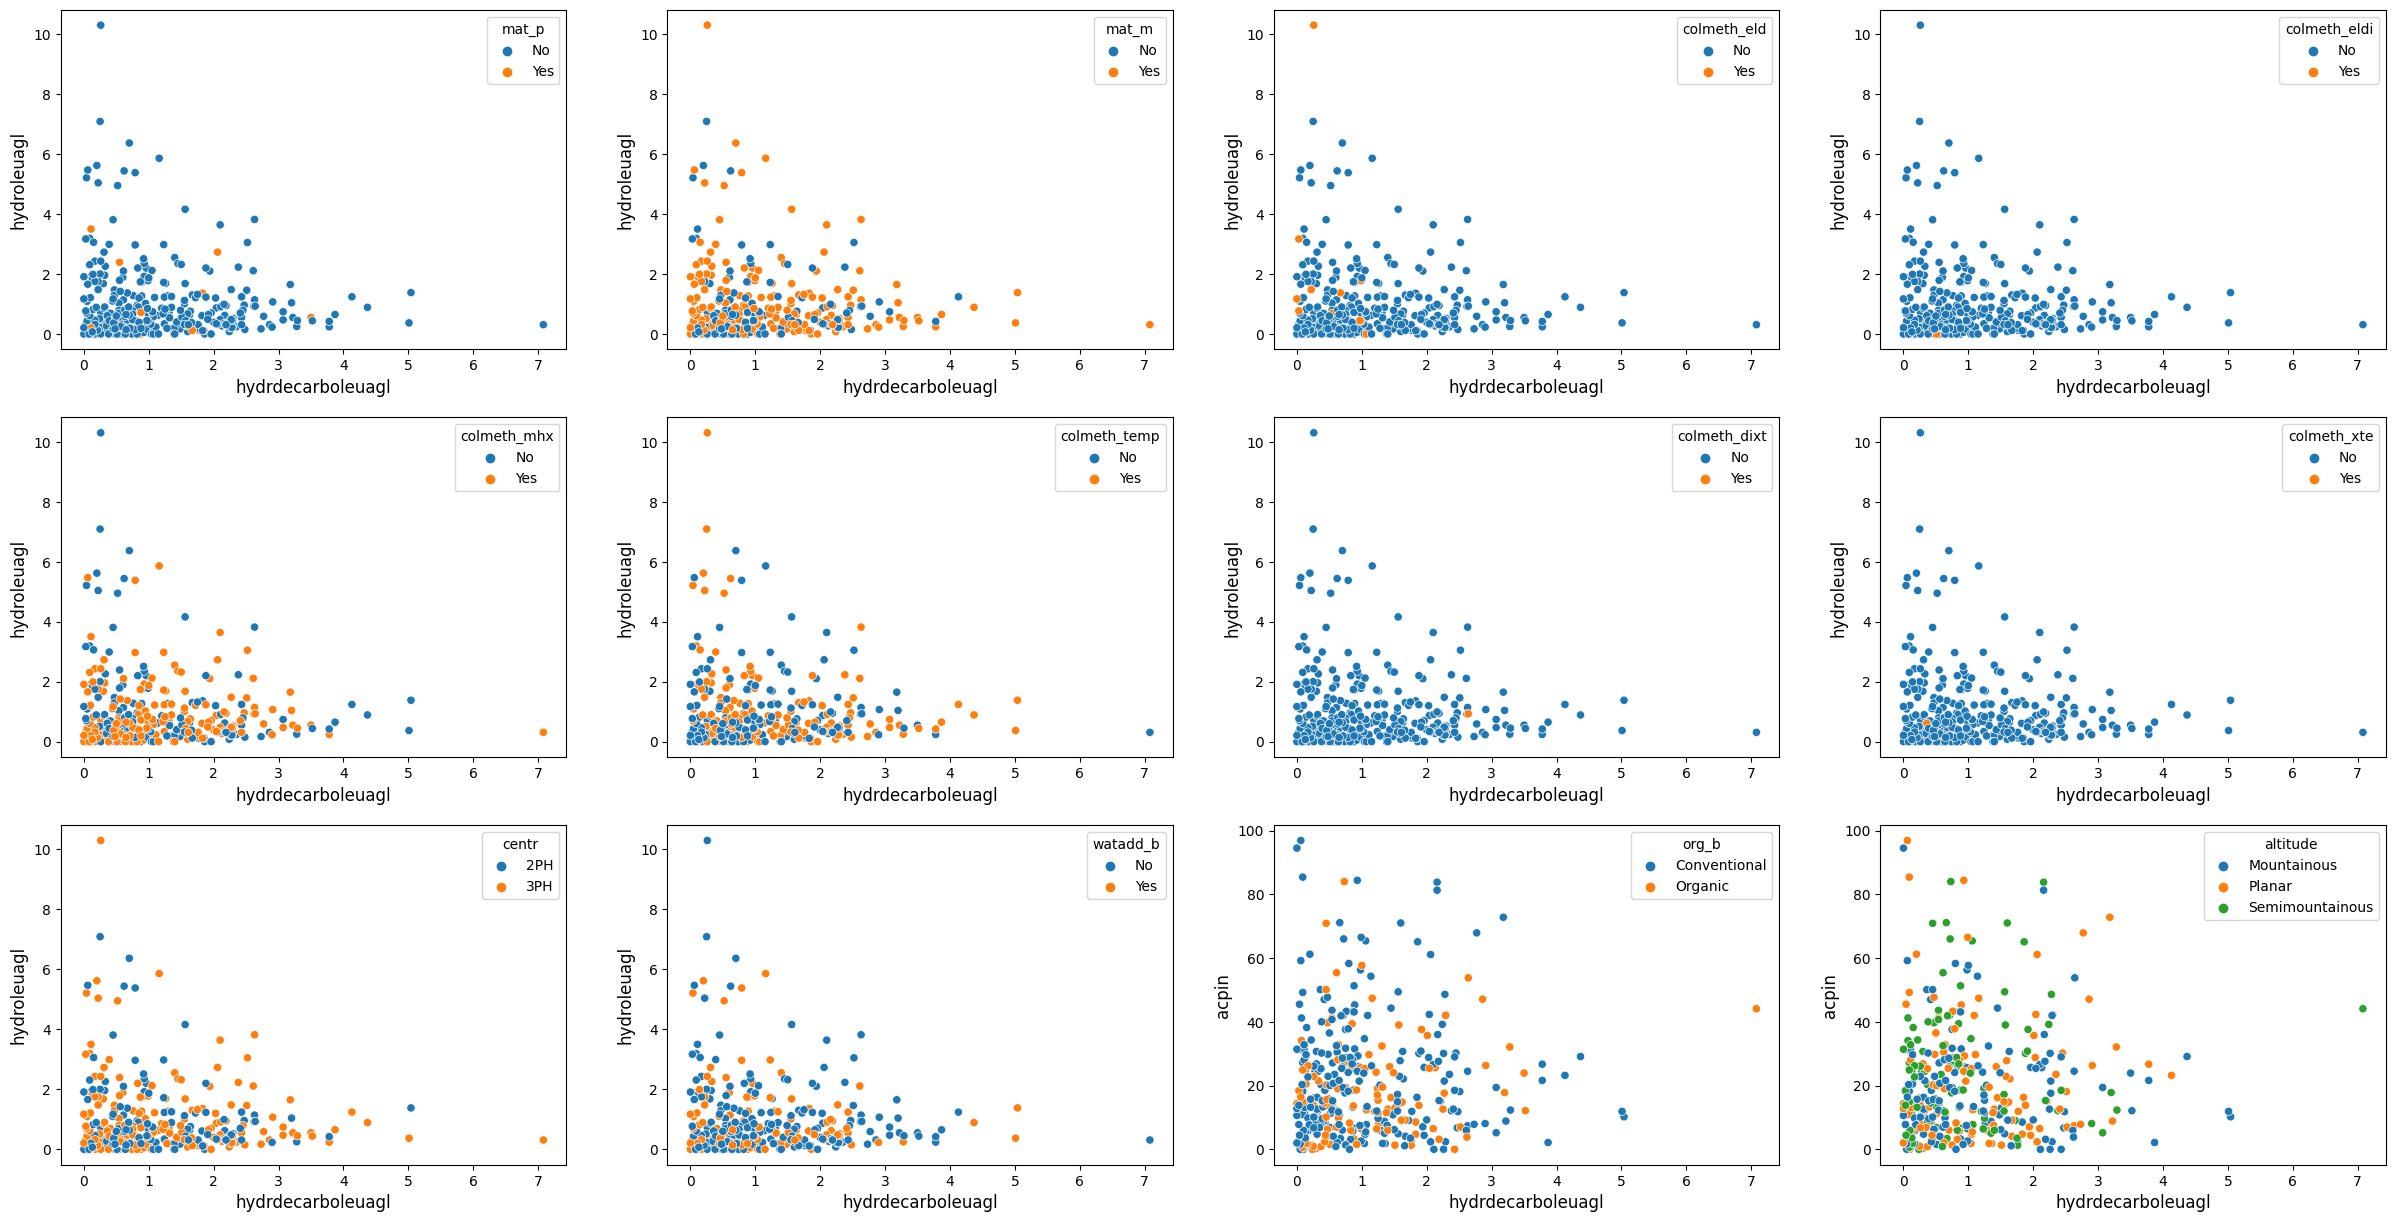

In [100]:
f = next(cs)
plt.show()

Οι πιθανοί συνδιασμοί στόχων-ζευγών χημικών παραμέτρων είναι πάρα πολλοί ($\approx 15.000.000$). Η εξαίταση τους με διαγράμματα διασποράς είναι ανέφικτη. Σε κάθε περίπτωση εξαιτάζοντας τυχαίο υποσύνολο των συνδιασμών αυτών δεν φαίνονται ιδιαίτερες τάσεις στα δεδομένα. Υπάρχει εκτενής αλληλοεπικάλυψη σε όλες τις κατηγορίες

### Συσχετίσεις

#### Γενικές

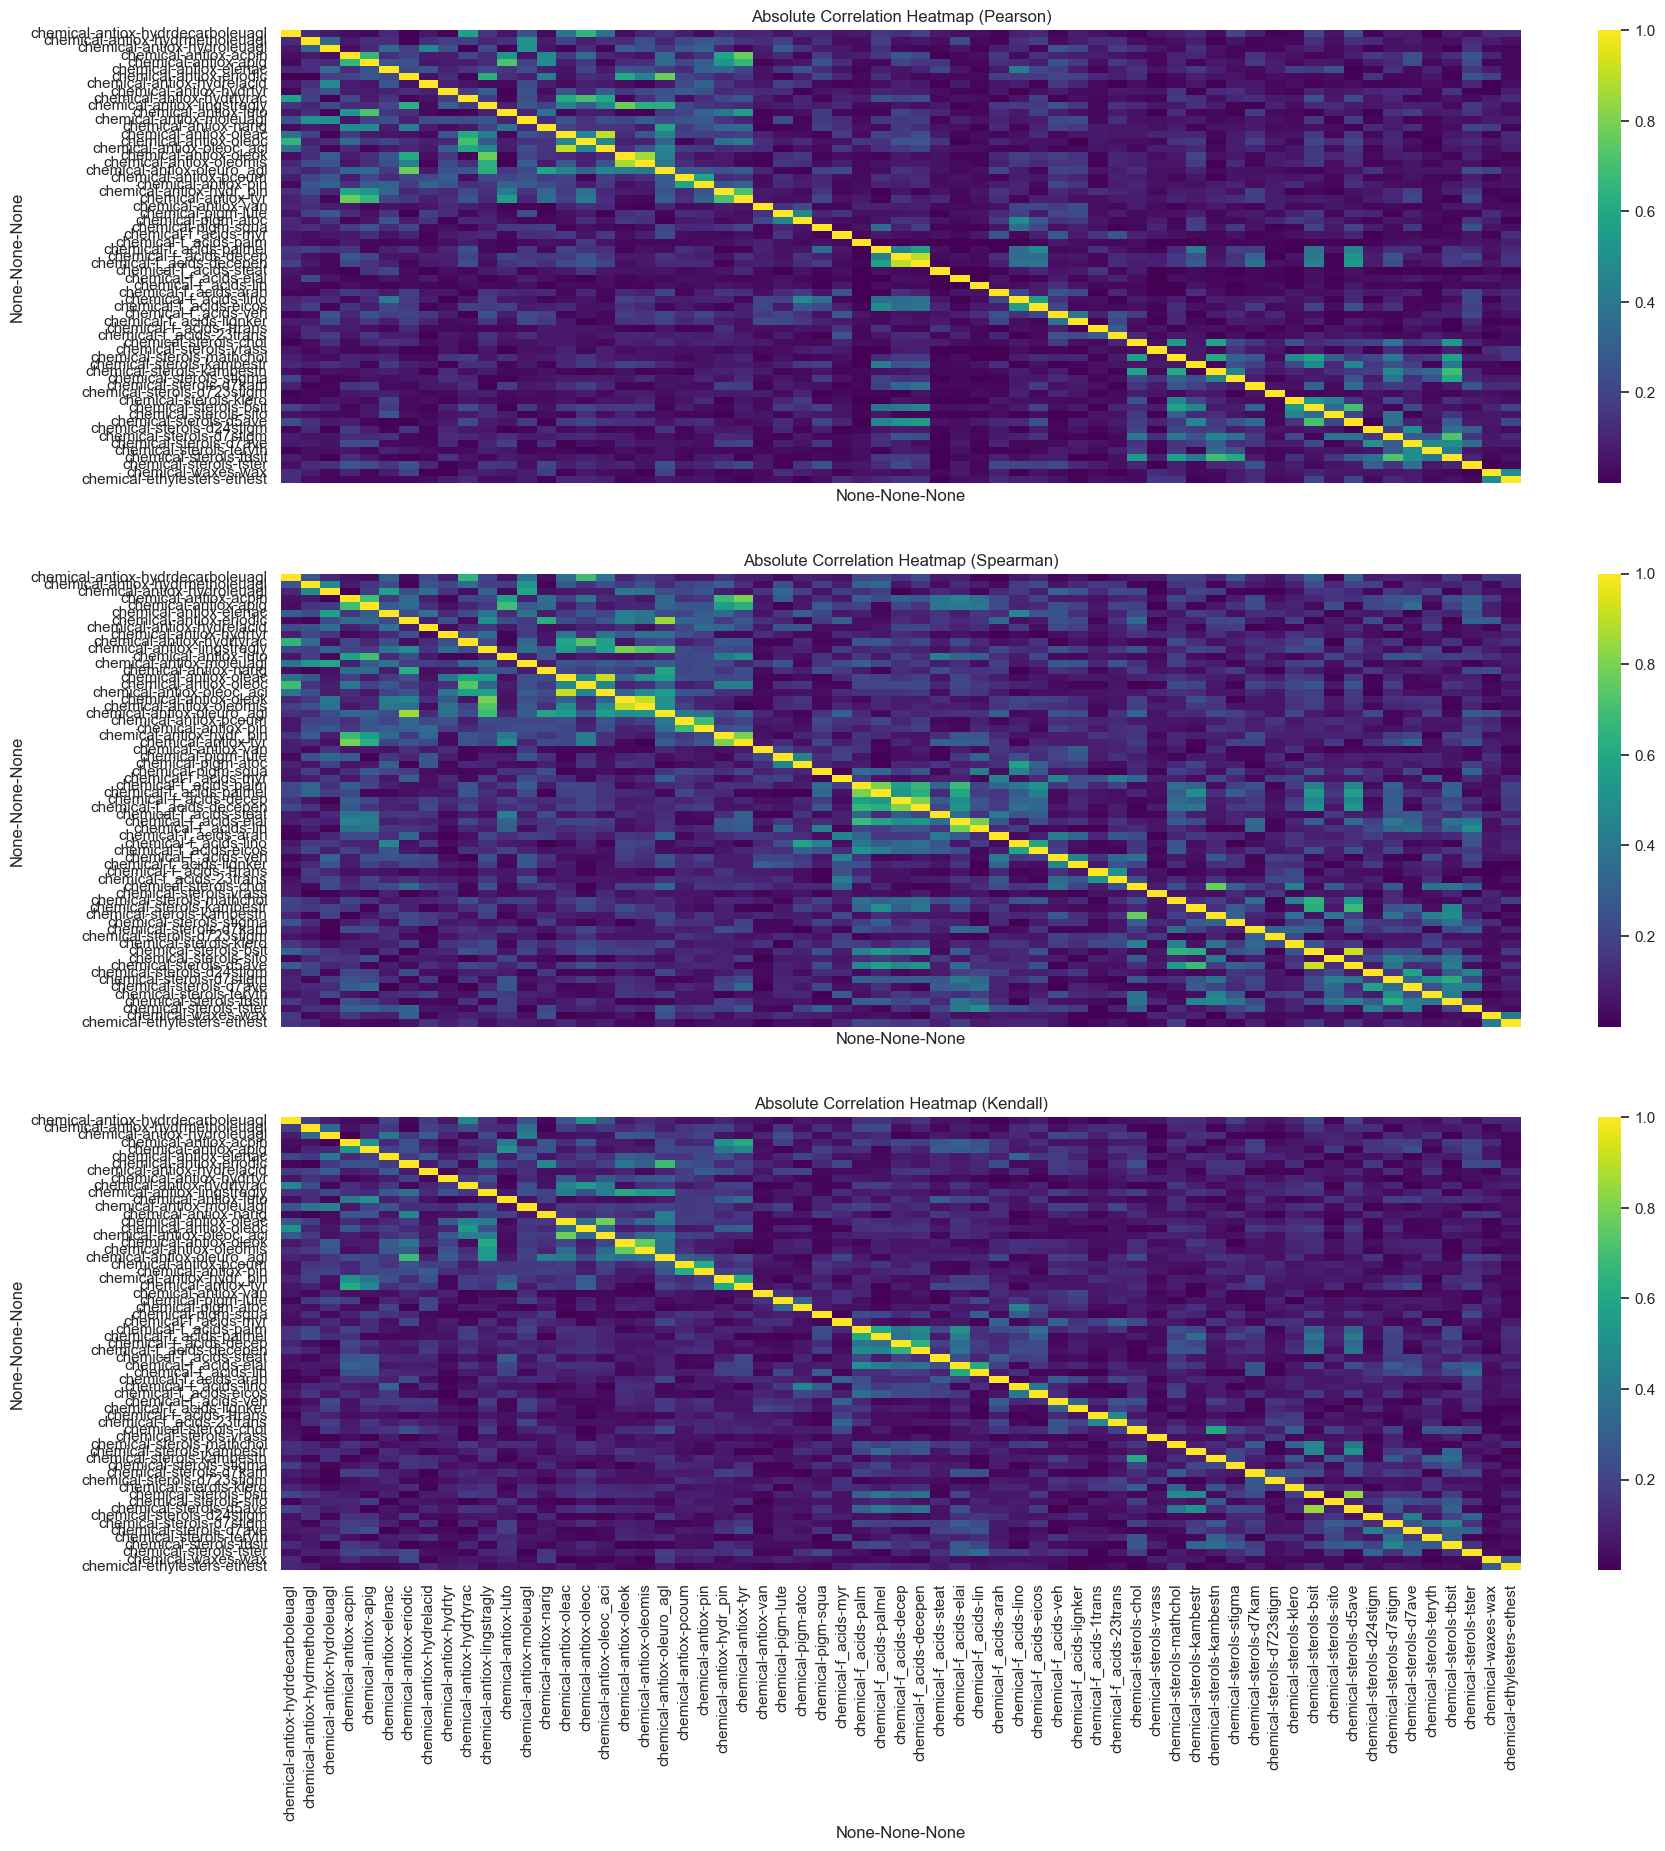

In [134]:
fig, axs = plt.subplots(nrows=3,ncols=1, sharex=True, sharey=True)
sns.heatmap(
    chem_indicators.corr(method='pearson').applymap(np.abs),
    cmap='viridis', xticklabels=True, yticklabels=True, ax=axs[0])
axs[0].set_title('Absolute Correlation Heatmap (Pearson)')
sns.heatmap(
    chem_indicators.corr(method='spearman').applymap(np.abs),
    cmap='viridis', xticklabels=True, yticklabels=True, ax=axs[1])
axs[1].set_title('Absolute Correlation Heatmap (Spearman)')
sns.heatmap(
    chem_indicators.corr(method='kendall').applymap(np.abs),
    cmap='viridis', xticklabels=True, yticklabels=True, ax=axs[2])
axs[2].set_title('Absolute Correlation Heatmap (Kendall)')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.show()

Επειδή οι συσχετίσεις *Pearson* βασίζονται σε **γραμμικές** σχέσεις ενώ οι *Kendall* και *Spearman* σε **μονότονες** μικρότερες τιμές του πρώτου συντελεστή έναντι των υπόλοιπων δύο υπονοούν την ύπαρξη μη-γραμμικότητας και μπορούν και οι ίδιες να είναι μικρότερες των πραγματικών εάν οι πραγματικές συσχετίσεις δεν είναι μονότονες. Συγκρίνοντας τα άνω υπάρχουν ενδείξεις μη γραμμικότητας, γιατί οι συσχετίσεις *Peason* φαίνονται ασθενώς μικρότερες.

θα χρησιμοποιηθεί η τεχνική Ανάλυσης Κύριων Συνιστωσών για να διερευνηθή ο πίνακας συνδιακυμάνσεων, λαμβάνοντας υπ' όψιν την ύπαρξη μη-γραμμικότητας

In [135]:
cdf.loc[:,[('origin','location','zn'), ('origin','location','loc') ]+ list(("origin","cultivation", e) for e in cdf.loc[:,('origin', 'cultivation')].columns )]

/tmp/ipykernel_43080/2980327359.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  cdf.loc[:,[('origin','location','zn'), ('origin','location','loc') ]+ list(("origin","cultivation", e) for e in cdf.loc[:,('origin', 'cultivation')].columns )]


origin                                            
    location           cultivation                      
          zn     loc         org_b         altitude  wat
0          6  LESVOS  Conventional      Mountainous   No
1          7  LESVOS  Conventional  Semimountainous  Yes
2          1  LESVOS  Conventional  Semimountainous  Yes
3          1  LESVOS  Conventional  Semimountainous  Yes
4          1  LESVOS  Conventional  Semimountainous   No
..       ...     ...           ...              ...  ...
530        1   CHIOS       Organic  Semimountainous  Yes
531        1   CHIOS       Organic      Mountainous   No
532        1   CHIOS       Organic      Mountainous   No
533        1   CHIOS       Organic      Mountainous   No
534        1   CHIOS       Organic  Semimountainous  Yes

[535 rows x 5 columns]

In [137]:
# Data selection
origin_targets = cdf.loc[:,("origin", ['cultivation','location'])  ].drop(('origin', 'location', 'zn'), axis=1)
m1 = origin_targets.isna().any(axis=1)
chem_indicators =cdf.loc[:,(['chemical'])]
m2 = chem_indicators.isna().any(axis=1)
m = pd.concat([m1, m2],axis=1).any(axis=1)
chem_indicators, origin_targets = chem_indicators.loc[~m,:], origin_targets.loc[~m,:]

[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [63] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [44] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [63] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[44]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


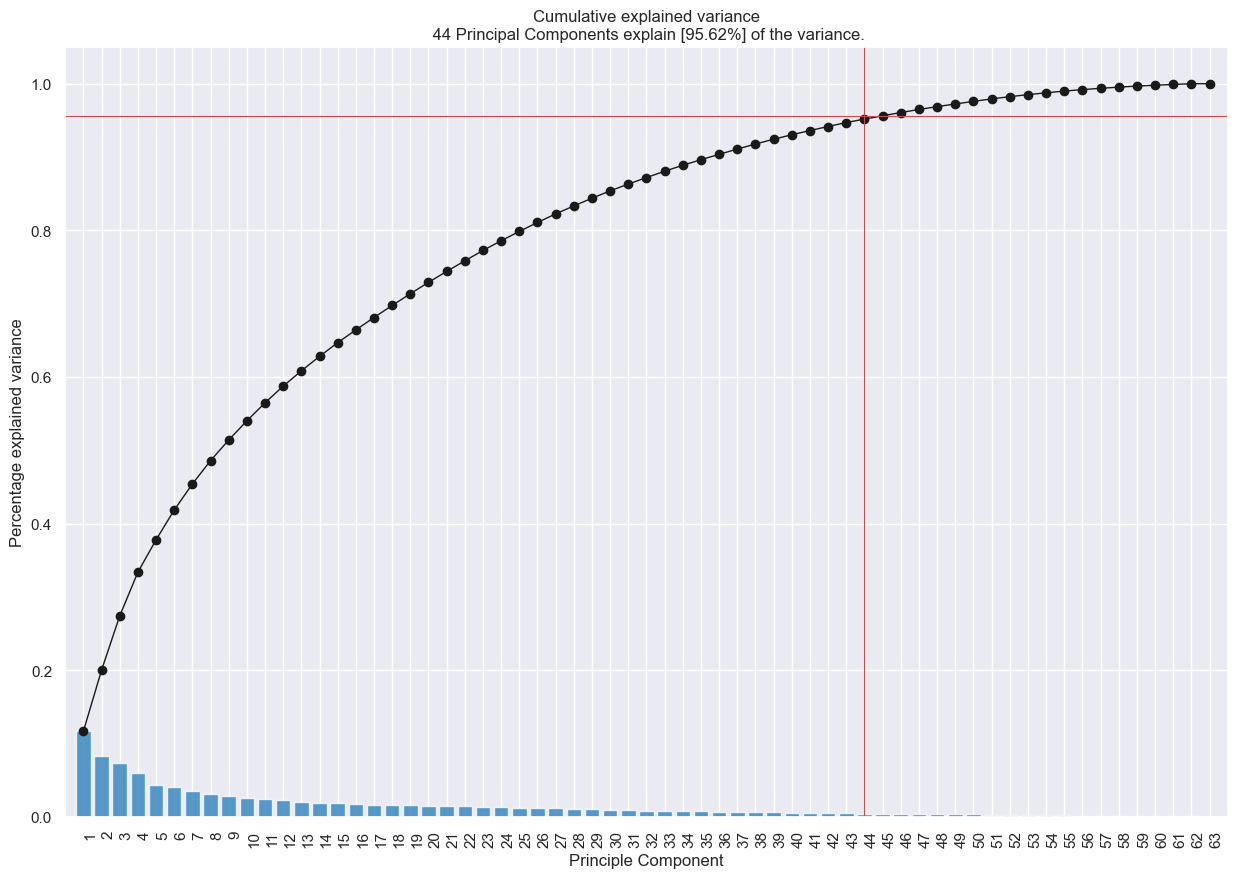

(<Figure size 1500x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Cumulative explained variance\n 44 Principal Components explain [95.62%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

In [138]:
# Load library
from pca import pca

# Initialize pca with default parameters
model = pca(normalize=True)

# Fit transform

results = model.fit_transform(
    chem_indicators.values, col_labels = tidy_multiindex(chem_indicators).columns.values,
    row_labels=tidy_multiindex(origin_targets).replace(r_core_mappings).iloc[:,-2].values)

# Plot the explained variance
model.plot()

Στο διάγραμμα επεξηγούμενης % διακύμανσης φαίνεται οτι υπάρχει περιορισμένη δυνατότητα μείωσης διαστάσεων. Η πρώτη κύρια συνιστώσα απορροφά μόλις το $\approx 10\%$ της συνολικής διακύμανσης. Αυτό υποννοεί μη-γραμμικές συσχετίσεις ή απουσία συσχετίσεων

[pca] >Plot PC1 vs PC2 with loadings.


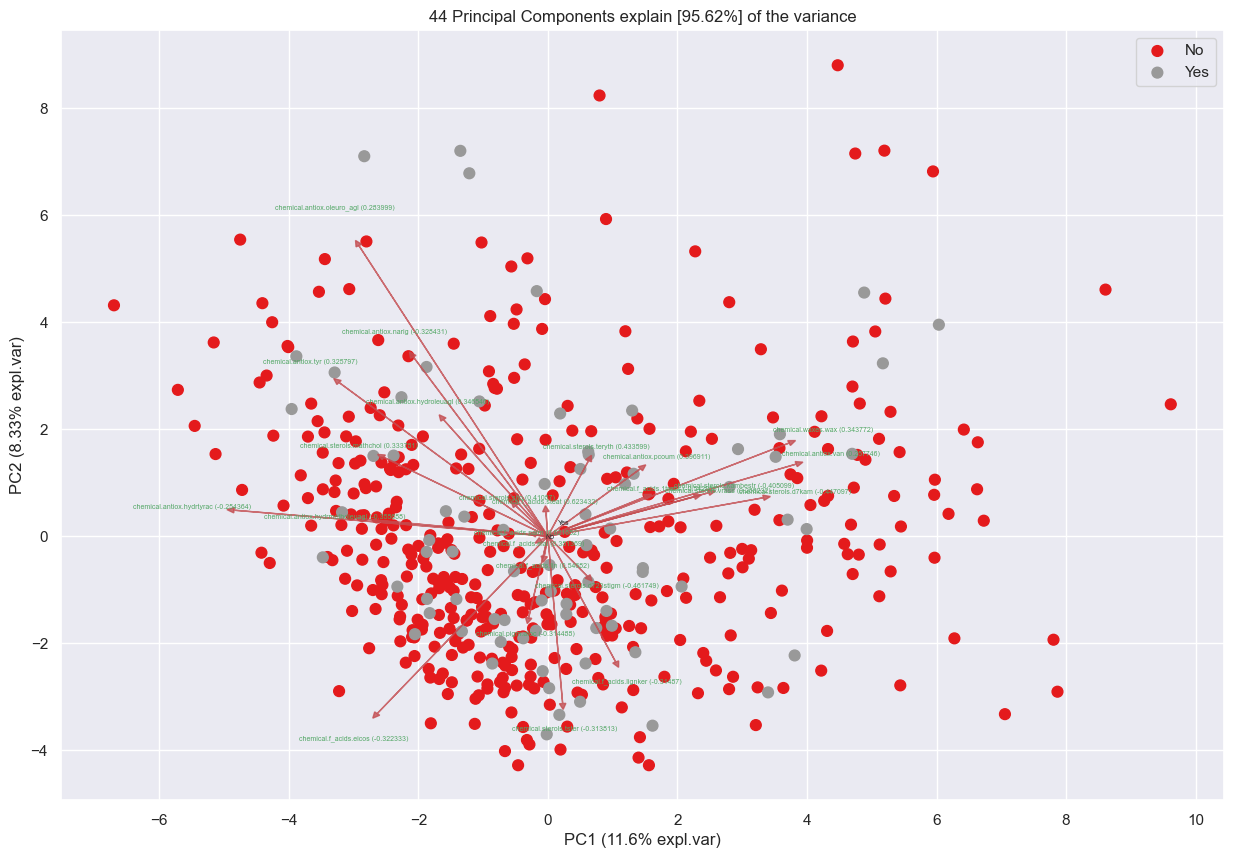

In [148]:
model.biplot()
plt.show()

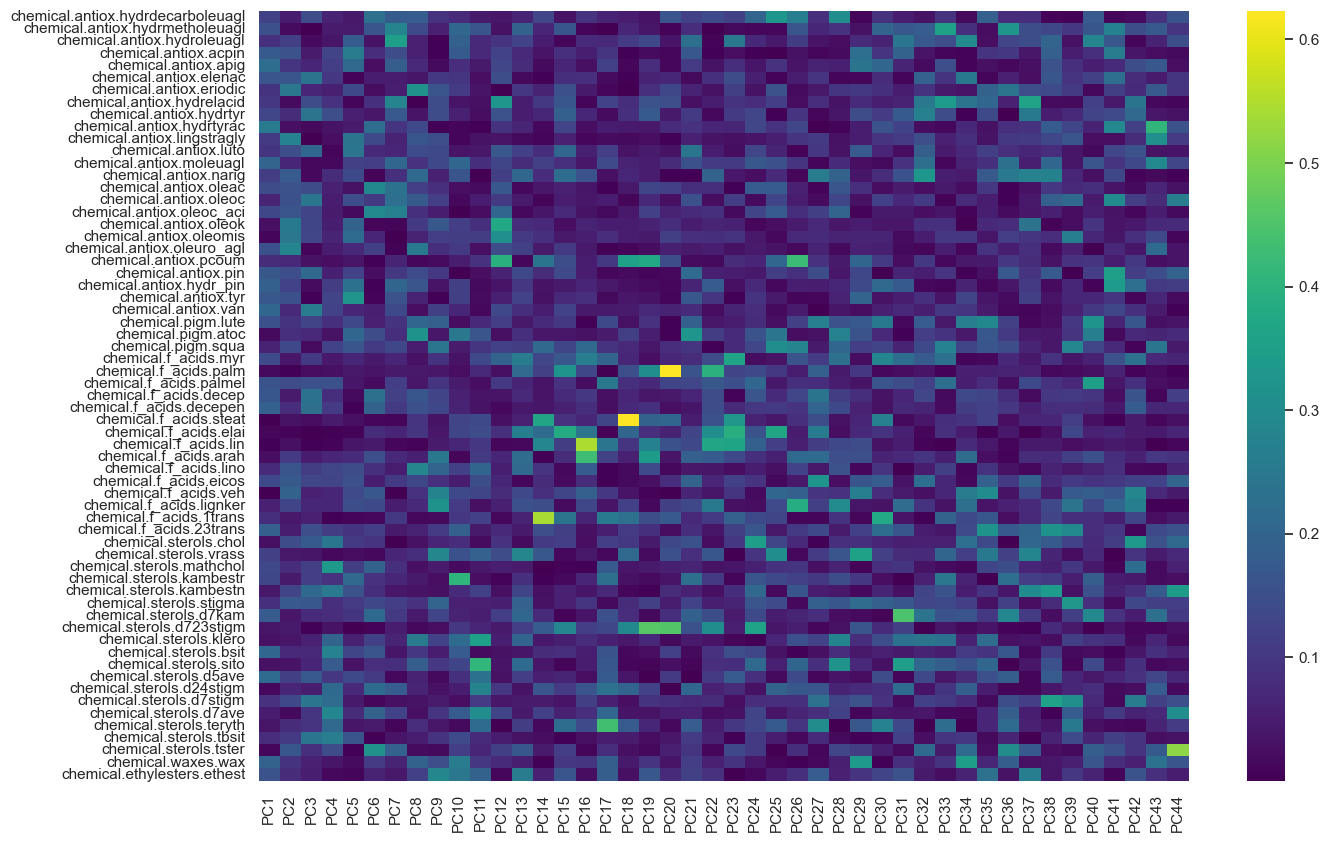

In [149]:
sns.heatmap(model.results['loadings'].applymap(np.abs).T,
            cmap='viridis', xticklabels=True, yticklabels=True)
plt.show()

Ομοίως εξαιτάζοντας τα φορτία εντοπίζεται περιορισμένη δομή στον πίνακα συσχετίσεων. Είναι πιθανό να οφειλεταί σε μη γραμμικότητα. Θα μπορούσε να γίνει ποιό αποτελεσματική διαστατική μείωση με **αυτοκωδικοποιητή** (*autoencoder*).

## Μοντελοποίηση

### Χαρακτηριστικά Γεωγραφικής Προέλευσης

#### Τοποθεσία

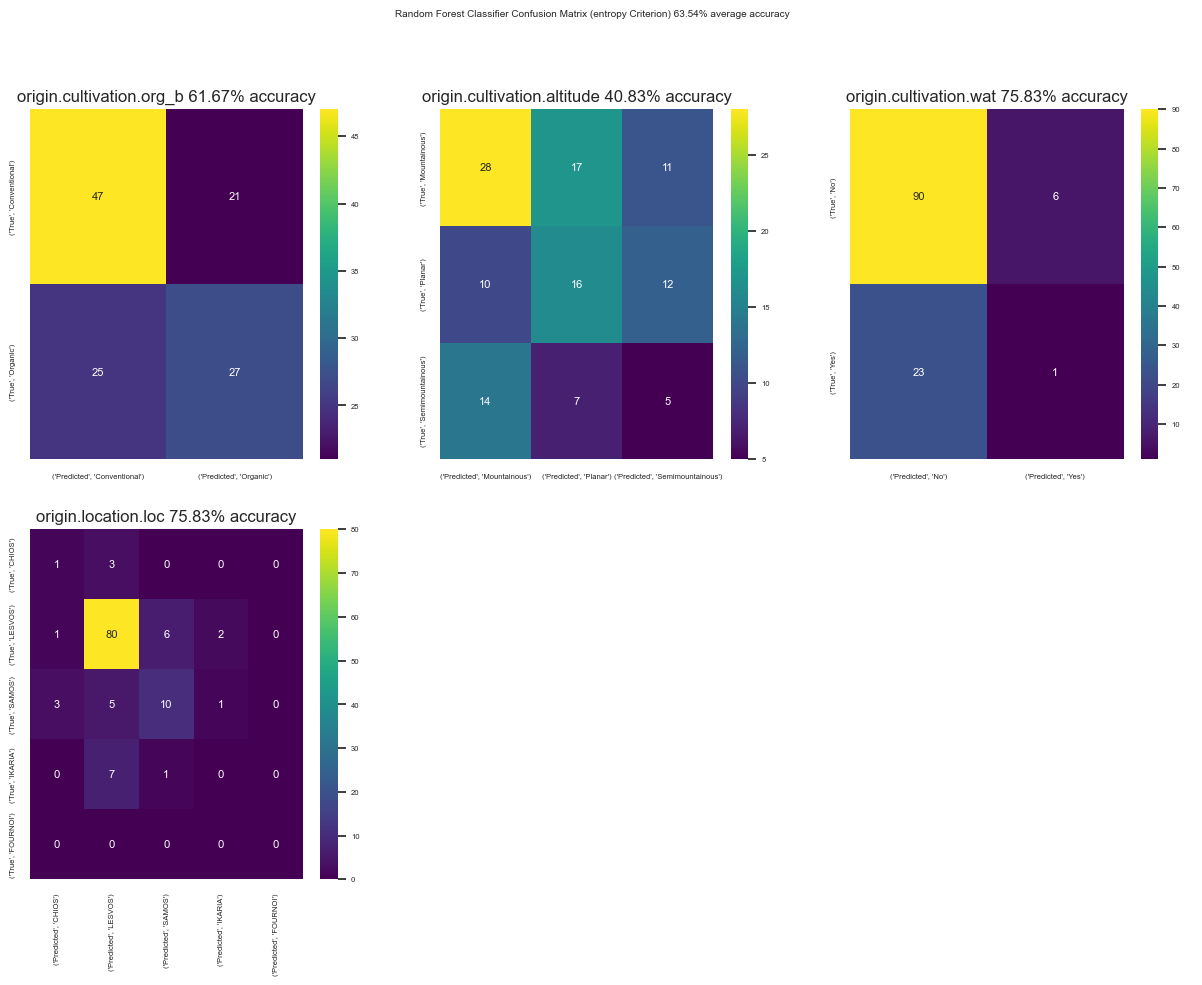

In [169]:
def rand_forest(train_data:tuple=(None, None), test_data:tuple =(None, None),
                criterion:str='entropy', n_estimators:int=100):
    sns.set(font_scale=0.5)
    X_train, Y_train = train_data
    X_test, Y_test = test_data
    model = RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=n_estimators)
    c_matrix= {}
    accs = {}
    for col in Y_train.columns:
        model.fit(X_train, Y_train.loc[:,col])
        levels = Y_train.loc[:, col].unique()
        Y_hat = pd.DataFrame(data=model.predict(X_test))
        c_matrix[col] = pd.DataFrame(data=confusion_matrix(Y_test.loc[:,col], Y_hat, labels=Y_train.loc[:,col].unique()),
                                     index = [('True', level) for level in levels], columns = [('Predicted', level) for level in levels] )
        accs[col] = sklearn.metrics.accuracy_score(Y_test.loc[:,col], Y_hat)
    rows=math.ceil(Y_train.shape[1]/3)
    fig, axs = plt.subplots(nrows=rows, ncols=3)
    fig.suptitle(f"Random Forest Classifier Confusion Matrix ({criterion} Criterion)"+\
                  " {:.2%}".format(np.average(list(v for k,v in accs.items()) ))+" average accuracy")
    for (i,j), (var, matrix) in itertools.zip_longest(product(range(rows), range(3)), c_matrix.items(), fillvalue=(None, None)):
        if matrix is not None:
            sns.heatmap(c_matrix[var], annot=True, cmap='viridis', ax=axs[i,j], annot_kws={"size": 8})
            axs[i,j].set_title(("{} {:.2f}% accuracy".format(var, accs[var]*100)), fontsize=12)
        else:
            axs[i,j].axis('off')
    return model, fig
pc = sklearn.decomposition.PCA(n_components=.95).fit_transform(chem_indicators)
chems = pd.DataFrame(data=pc, columns=list("Principal Ax {}".format(i) for i in range(1, pc.shape[1]+1)   ))
Xtr, Xte, Ytr, Yte = train_test_split(chems, tidy_multiindex(origin_targets), random_state=2)
rand_forest((Xtr, Ytr), (Xte, Yte))
plt.show()

In [ ]:
def preprocessing_data(data:pd.DataFrame,predictors:typing.Optional[typing.Callable]=None,
                           targets:typing.Optional[typing.Callable] = None ,
                           tasks:list[typing.Callable]=[sklearn.preprocessing.MinMaxScaler()]):
    '''
        Utility method to automate data preprocessing prior to model fit
        
        Args:
        ----
        
            - data:pandas.DataFrame := The data to process
            
            - predictors:Callable := A callable filter that takes the dataframe
            and returns predictor variables
            
            - targets:Callable := A callable filter that takes the dataframe as
            input and returns the variables to predict
            
            - tasks:list[Callable] := A list of callables representing the processing
            operations to chain together. Each should take only one argument `df` the
            data to process. Call with `functool.partial` to initialize all other
            arguments
            
        Returns:
        -------
        
            - (ndf,):tuple[pandas.DataFrame, None] := When no target/indicator split
            is provided, returns a tuple, whose first element is the processed
            dataframe
            
            - (indicators, targets):tuple[pandas.DataFrame, pandas.DataFrame] := 
            When a target/indicator split is provided, return a tuple of dataframes
            where the first one is the indicators dataframe and the second is the
            target dataframe
    '''
    

In [ ]:
# Data prep
def data_prep(X, Y, dummify:bool=False, scaleX:typing.Union[bool, list[str]]=['']):
    if isinstance(X.columns, pd.MultiIndex):
        _X = tidy_multiindex(X)
    else:
        _X = X
    X = pd.DataFrame(data=sklearn.preprocessing.MinMaxScaler().fit_transform(_X),
                    columns=_X.columns, index=_X.index)
    if isinstance(Y.columns, pd.MultiIndex):
       _Y =  tidy_multiindex(Y)
    else:
        _Y = Y
    if dummify:
        _Y = pd.get_dummies(_Y)
    Y = tidy_multiindex(_Y.replace(r_core_mappings))
    Xtrain, Xtest, Ytrain, Ytest =sklearn.model_selection.train_test_split(X, Y, random_state = 44)
    return Xtrain, Xtest, Ytrain, Ytest

In [ ]:
xtrain,xtest, ytrain, ytest = data_prep(chem_indicators, origin_targets)
# m,fig = rand_forest(train_data =(Xtrain, Ytrain), test_data=(Xtest, Ytest))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
# from itertools import product
# from sklearn.model_selection import train_test_split


# validation_iters = 10
# # VERY messy. Look into xarray
# t1 = {}
# acc = {}
# s = True
# for i in range(validation_iters):
#     model = RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=100)
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
#     for col in Y.columns:
#         model.fit(X_train, Y_train.loc[:,col])
#         levels = Y_train.loc[:, col].unique()
#         Y_hat = model.predict(X_test)
#         c = confusion_matrix(Y_test.loc[:,col], Y_hat, labels=[v for k, v in mappings[col].items()], normalize='true')
#         t1[col] = c
#     if s:
#         s=not s
#         t2 = t1
#     else:
#         for k, v in t1.items():
#             t2[k] = np.dstack(tuple([v, t1[k]]))
# for k, v in t2.items():
#             levels = Y.loc[:,k].unique()
#             data = np.average(v, axis=2)
#             t2[k] = pd.DataFrame(data = data, index = [('True', level) for level in levels], columns = [('Predicted', level) for level in levels])
            
# fig, axs = plt.subplots(Y.shape[1]%3, 3)
# fig.suptitle("Confusion matrices for Random Forest Classifiers")
# for (i,j), (var, matrix) in zip(product(range(Y.shape[1]%3), range(3)), t2.items()):
#     sns.heatmap(t2[var], annot=True, cmap='viridis', ax=axs[i,j])
#     axs[i,j].set_title(var, fontsize=12)

In [ ]:
def logit_reg(train_data:tuple=(None, None), test_data:tuple =(None, None),
                class_weight:typing.Optional[str]=None, max_iter:int=10000):
    X_train, Y_train = train_data
    X_test, Y_test = test_data
    targets = Y_train.columns
    models = {}
    for target in targets:
        factors =  Y_train.loc[:,target].unique()
        y_train = Y_train.loc[:,target]
        y_test =  Y_test.loc[:, target]
        logitmodel = sklearn.linear_model.LogisticRegression(max_iter=max_iter, class_weight=class_weight)
        logitmodel.fit(X_train, y_train)
        y_pred = logitmodel.predict(X_test)
        model = dict(
            model = logitmodel,
            error_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels =factors),
                                        columns = [('Predicted', e) for e in factors],
                                        index = [('True', e) for e in factors]
            ),
            accuracy = sklearn.metrics.accuracy_score(y_test, y_pred),
            score = logitmodel.score(X_train, y_train),
            decision_function = logitmodel.decision_function(X_train))
        models[target] = model
    rows = math.ceil(Y_train.shape[1]/3)
    fig, axs = plt.subplots(ncols = 3, nrows = rows )
    fig.suptitle("Confusion matrices for Logistic Regression Classifier - {weight}".format(weight='Unweighted ' if class_weight is None else class_weight))
    for (i, j), (target, model) in itertools.zip_longest(product(range(rows),range(3) ), models.items(), fillvalue=(None,None)):
        if model is not None:
            sns.heatmap(model['error_matrix'], annot=True, cmap='viridis', ax = axs[i,j])
            axs[i,j].set_title((target+" {:.2%} accuracy".format(model['accuracy'])))
        else:
            axs[i,j].axis('off')
Xtr, Xte, Ytr, Yte = train_test_split(std_scale(chem_indicators), tidy_multiindex(origin_targets), random_state=44)
logit_reg((Xtr, Ytr), (Xte, Yte))

In [ ]:
rowwise_value_counts(origin_targets)

In [ ]:
def rebalance():
    from imblearn.over_sampling import ADASYN, SMOTE

    X = chem_indicators
    Y = origin_targets
    X_train, X_test, Y_train, Y_test = train_test_split(chem_indicators, origin_targets, test_size=0.2, random_state=44)
    X_train, X_test = std_scale(X_train), std_scale(X_test)
    targets = Y.columns
    models = {}

    for target in targets:
        factors =  origin_targets.loc[:,target].unique()
        y_train = Y_train.loc[:,target]
        y_test =  Y_test.loc[:, target]
        logitmodel = LogisticRegression(max_iter=10000)
        adasyn = ADASYN(random_state=44, sampling_strategy='minority', n_neighbors=2)
        smote = SMOTE(k_neighbors=2)
        logitmodel.fit(*smote.fit_resample(X_train, y_train))
        y_pred = logitmodel.predict(X_test)
        model = dict(
            model = logitmodel,
            error_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels =factors),
                                        columns = [('Predicted', e) for e in factors],
                                        index = [('True', e) for e in factors]
            ),
            accuracy = accuracy_score(y_test, y_pred),
            score = logitmodel.score(X_train, y_train),
            decision_function = logitmodel.decision_function(X_train))
        models[target] = model

    rows = ceil(len(models)/3)

    fig, axs = plt.subplots(ncols = 3, nrows = rows )
    fig.suptitle("Confusion matrices for Logistic Regression Classifier on Location target variables, with ADASYN")
    for (i, j), (target, model) in zip(product(range(3), range(rows) ), models.items()):
        sns.heatmap(model['error_matrix'], annot=True, cmap='viridis', ax = axs[j, i])
        axs[j,i].set_title(target)

### Γκαουσιανές Διεργασίες (*Gaussian Processes*)

In [ ]:
X = tidy_multiindex(chem_indicators)
Y = pd.get_dummies(tidy_multiindex(origin_targets.loc[:,(['origin'],['location'], ['loc'])]))

In [ ]:
with pymc.Model() as bayes_location_model:
    η = 1.0
    λ = 1.0
    Κ = η**2*pymc.gp.cov.ExpQuad(X.shape[1], ls=λ)
    gp = pymc.gp.Latent(cov_func=Κ)
    f = pymc.math.sigmoid(gp.prior("f", X=X.values))
    y = pymc.Categorical("y", p = f, observed=Y)
    pdata1 = pymc.sample_prior_predictive(samples=100, random_seed=44)

In [ ]:
az.plot_ppc(pdata1)

In [ ]:
with bayes_location_model:
    idata1 = pymc.sample(2000,return_inferencedata=True)
    pps1 = pymc.sample_posterior_predictive(idata)

In [ ]:
az.plot_trace(idata1, var_names=['y'])

In [ ]:
az.plot_ppc(pps1)

In [ ]:
with pymc.Model() as bayes_location_model_logits:
    η = 1.0
    λ = 1.0
    Κ = η**2*pymc.gp.cov.ExpQuad(X.shape[1], ls=λ)
    gp = pymc.gp.Latent(cov_func=Κ)
    f = gp.prior("f", X=X.values)
    p = pymc.Deterministic("p", aesara.tensor.nnet.softmax(f))
    prob = pymc.Multinomial("prob", 1, p, observed=Y)
    pdata = pymc.sample_prior_predictive(samples=100, random_seed=44)

In [ ]:
with bayes_location_model:
    idata2 = pymc.sample(2000,return_inferencedata=True)
    pps2= pymc.sample_posterior_predictive(idata)


In [ ]:
az.plot_ppc(pps2, var_names=['p_rotated_'])

##### ANN με GEKKO

In [ ]:
def gekko_ANN(X:pd.DataFrame, Y:pd.DataFrame, layers:list[tuple[str,typing.Optional[int]]]=[('relu', None)],
             exit_nodes:typing.Optional[int]=None, exit_activation:str='linear'):
    from gekko import brain, GEKKO
    model = GEKKO(remote=False)
    model.options.MAX_MEMORY = 7    
    br = brain.Brain(m=model)
    N, M = Y.shape[1], X.shape[1]
    dstring = lambda e: e if e is not None else 'relu'
    istring = lambda e: e if e is not None else M
    processed_layers = [(dstring(e1), istring(e2)) for (e1, e2) in layers]
    ext_sz = exit_nodes if exit_nodes is not None else N
    br.input_layer(M)
    for activation, nodes in processed_layers:
        if activation == 'relu':
            br.layer(relu=nodes)
        elif activation == 'gaussian':
            br.layer(gaussian=nodes)
        elif activation == 'tanh':
            br.layer(sigmoid = nodes)
        elif activation == 'bent':
            br.layer(bent=nodes)
        elif activation == 'leaky':
            br.layer(leaky=nodes)
    br.output_layer(ext_sz, activation=exit_activation)
    try:
        br.learn(X.values.T, Y.values.T)
    except FileNotFoundError:
        raise RuntimeError('Encountered infinities. Network failed to converge')
    return br

In [ ]:
X = pd.DataFrame(data = sklearn.decomposition.PCA(n_components = .95).fit_transform(tidy_multiindex(chem_indicators) ))
Y = tidy_multiindex(origin_targets.replace(r_core_mappings))

# def deploy_daemon(func, *args, **kwargs):
#     f = functools.partial(gekko_ANN,X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)] )
#     multiprocessing.Process(target = )

# f = functools.partial(gekko_ANN,X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)] )
# p = multiprocessing.Process(target = f)
# multiprocessing.Process(target= gekko_ANN(X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)])).start()

# ann = gekko_ANN(X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)])

#### ANN με Tensorflow

In [ ]:
# from copy import copy
# rlayers = list((math.ceil(e), 'tanh') for e in range(X.shape[1], 2, -10) )
# llayers = copy(rlayers)
# llayers.reverse()
# layers = rlayers+llayers
# layers

In [ ]:
# tf_autoencoder(Xtrain, Xtrain, Xtrain, Xtrain, loss='mse', layers=rlayers, epochs=1000)

In [ ]:
layers = [(math.ceil(45), 'tanh') for _ in range(1,6)]
layers

In [ ]:
 from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=44)
Xr, Yr = ADASYN(random_state=44).fit_resample(chem_indicators, origin_targets.replace(r_core_mappings).iloc[:,[0]])
balancer = {4:22,5:33}

In [ ]:
def oversample(X, Y, sampling_strategy:list[float, str]):
    sentinel=True
    Yprime= Y.replace(r_core_mappings)
    for (idx, col), sampling in zip(enumerate(Yprime.columns), sampling_strategy):
        if sampling[1] is None:
            ada = ADASYN(random_state=44, sampling_strategy=sampling[0])
        else:
            ada = ADASYN(random_state=44, sampling_strategy=sampling[0], n_neighbors=sampling[1])
       
        _X, _Y = ada.fit_resample(X, Yprime.iloc[:,[idx]])
        if not sentinel:
            Yr =pd.concat([Yr, _Y], axis=1)
        else:
            Yr = _Y
            Xr = _X
            sentinel=False
    Xr = pd.DataFrame(data = sklearn.decomposition.PCA(n_components = .99).fit_transform(Xr ))
    return Xr, Yr
x,y=oversample(chem_indicators, origin_targets.iloc[:,[-1]], [
    (balancer,4), ('minority',None), (0.8,None), ('minority', 4), (0.7, None)])
Xtrain, Xtest, Ytrain, Ytest = data_prep(x,y, dummify=True)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
m = tf_model(Xtrain, Xtest, Ytrain, Ytest, factivation = 'sigmoid', 
        loss='categorical_crossentropy', metrics = ['accuracy'],
        epochs=4000, layers=layers , callbacks=[tensorboard_callback],
        verbosity=1)

### Ποικηλίες

In [ ]:
cdf[cdf.loc[:,('origin', 'cultivar')].isna().any(axis=1)].loc[:, ('origin', 'cultivar')]

In [ ]:

with pymc.Model() as var_model:
    pass